In [16]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from classy import Class
from matplotlib.lines import Line2D
from smt.sampling_methods import LHS
from matplotlib.pyplot import cm
from uqpylab import sessions
from scipy.interpolate import interp1d
from scipy.spatial.distance import pdist
import statistics as st
import os, sys, warnings
from configparser import ConfigParser
from itertools import chain
import math
import seaborn as sns
from collections import defaultdict
from matplotlib.ticker import LogLocator

def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))
    
data_kgb = nested_dict(5, list)
data_kev = nested_dict(5, list)

data_kgb_l = nested_dict(5, list)
data_kgb_s = nested_dict(5, list)

import os

# Global plot settings
plt.rc("text", usetex=True)
plt.rc("font", family="serif", size=25)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

# Where to save the figures

IMAGES_PATH = './images'
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="pdf", resolution=180):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    plt.savefig(path, format=fig_extension, dpi=resolution, bbox_inches='tight')

In [17]:
# === Input redshifts to show on the plots ===
target_z = [2, 1, 0.5, 0]  

# KGB-evolution

In [19]:
# ──────────────────────────────────────────────────────────────────────────────
#                       CONFIGURATION FLAG
use_all_sims = False # ← set to False to process *only* sim1, True to combine 3
show_sim_plots = True  # ← set to False if you dont want to see the simulation plots,
kgb_sim_data = True
# ──────────────────────────────────────────────────────────────────────────────

# 1) PARAMETERS FOR YOUR SIMULATIONS
sim1 = dict(path="/home/ahmad/kgb-master/data/Cross-correlation/ak3e6-ab0/",ngrid=1024, boxsize=400)

# sim1 = dict(path='/home/ahmad/kgb-master/data/3072-4000-ab=0/',
#             ngrid=3072, boxsize=4000)
sim2 = dict(path="/home/ahmad/kgb-master/data/4096-15000/", ngrid=4096, boxsize=15000)
# sim3 = dict(path='/home/ahmad/kgb-master/data/3072-8500/',
#             ngrid=3072, boxsize=8500)

sim3 = dict(path="/home/ahmad/kgb-master/data/3072-4000/", ngrid=3072, boxsize=4000)

# which simulations to stitch?
sims = [sim1]
if use_all_sims:
    sims += [sim2, sim3]


################################################################################################################
#                                              background file
if kgb_sim_data:
    with open(f"{sim1['path']}/file_background.dat") as f:
        lines = f.readlines()

    fourpiG_val = float(
        next(
            line.split("=")[1].strip() for line in lines if line.startswith("# fourpiG")
        )
    )
    H0_val = float(
        next(
            line.split("=")[1].strip()
            for line in lines
            if line.startswith("# H0[1/Mpc]")
        )
    )

    norm_kgb = np.sqrt(2 * fourpiG_val / 3) / H0_val

    bg_kgb = np.loadtxt(f"{sim1['path']}/file_background.dat")

    # scale factor and redshift
    a_kgb = bg_kgb[:, 2]
    z_kgb = bg_kgb[:, 3]

    # z_kgb = [0 if x < 0 else x for x in z_kgb]
    # z_kgb[-2], z_kgb[-1] = 0.01, 0

    # Conformal Hubble parameter and its derivative
    Hconf_kgb = bg_kgb[:, 5]
    Hconf_prime_kgb = bg_kgb[:, 6]
    Hconf_prime_prime_kgb = bg_kgb[:, 7]

    # alpha parameters and their derivatives
    alpha_K_kgb = bg_kgb[:, 17]
    alpha_B_kgb = bg_kgb[:, 18]
    alpha_K_prime_kgb = bg_kgb[:, 19]
    alpha_B_prime_kgb = bg_kgb[:, 20]

    # dark energy density and pressure and their derivatives
    rho_smg_kgb = bg_kgb[:, 13]
    p_smg_kgb = bg_kgb[:, 14]
    rho_smg_prime_kgb = bg_kgb[:, 15]
    p_smg_prime_kgb = bg_kgb[:, 16]
    cs2_kgb = bg_kgb[:, 21]

    H_hiclass = bg_kgb[:, 4]

    # other background values
    rho_cdm_kgb = bg_kgb[:, 8]
    rho_b_kgb = bg_kgb[:, 9]
    rho_crit_kgb = bg_kgb[:, 12]

############################################################################################################
#                                         hiclass ini parameters

parser = ConfigParser()
with open(f"{sim1['path']}/file_classparameters.ini") as lines:
    lines = chain(
        ("[top]",), lines
    )  # This line produce a fake section header called top
    parser.read_file(lines)

Omega_fld = float(parser.get("top", "Omega_fld"))
Omega_Lambda = float(parser.get("top", "Omega_Lambda"))
Omega_smg = float(parser.get("top", "Omega_smg"))

Omega_b = float(parser.get("top", "Omega_b"))
Omega_cdm = float(parser.get("top", "Omega_cdm"))
Omega_g = float(parser.get("top", "Omega_g"))
Omega_ur = float(parser.get("top", "Omega_ur"))

# Extract and parse the 'parameters_smg' string
expansion_smg_str = parser.get("top", "expansion_smg")
expansion_smg_list = expansion_smg_str.split(",")
Omega_kgb = float(expansion_smg_list[0].strip())

expansion_model_str = parser.get("top", "expansion_model")

############################################################################################################
#                                   KGB-evolution used.ini parameters

with open(f"{sim1['path']}/file_settings_used.ini") as lines:
    lines = chain(
        ("[top]",), lines
    )  # This line produce a fake section header called top
    parser.read_file(lines)

k_pivot = float(parser.get("top", "k_pivot"))
A_s = float(parser.get("top", "A_s"))
n_s = float(parser.get("top", "n_s"))
h = float(parser.get("top", "h"))

omega_b = float(parser.get("top", "omega_b"))
omega_cdm = float(parser.get("top", "omega_cdm"))


gravity_model = parser.get("top", "gravity_model")

# Extract and parse the 'parameters_smg' string
parameters_smg_str = parser.get("top", "parameters_smg")
parameters_smg_list = parameters_smg_str.split(",")

# Convert the first two parameters to floats
alpha_K_hat = float(parameters_smg_list[0].strip())
alpha_B_hat = float(parameters_smg_list[1].strip())


# Function to format numbers for LaTeX (reusing the previous function)
def format_scientific_latex(number):
    mantissa, exponent = f"{number:.1e}".split("e")
    exponent = exponent.lstrip("+").lstrip("0") or "0"
    return f"{mantissa} \\times 10^{{{exponent}}}"


# Format the alpha values
alpha_K_hat_latex = format_scientific_latex(alpha_K_hat)

# Extract and parse the 'parameters_smg' string
expansion_smg_str = parser.get("top", "expansion_smg")
expansion_smg_list = expansion_smg_str.split(",")

w_kgb = float(expansion_smg_list[0].strip())
w_a_kgb = float(expansion_smg_list[1].strip())

# n_kgb_numsteps   = float(parser.get("top", "n_kgb_numsteps"))
Courant_factor = float(parser.get("top", "Courant factor"))

#############################################################################################################3


##################################################################################
#                                                                                #
#                                                                                #
#                                 LINKING SIMULATIONS                            #
#                                                                                #
#                                                                                #
##################################################################################


# common list of P(k) suffixes
pknames = [
    "delta_kgb",
    "delta",
    "phi",
    "pi_k",
    "zeta",
    "deltakgb_deltam",
    "B",
    "hij"
]

# read your redshifts once (always from sim1’s ini)
z = []
with open(f"{sim1['path']}/file_settings_used.ini") as f:
    for line in f:
        if line.strip().startswith("Pk redshifts"):
            z = [float(x) for x in line.split("=")[1].split("#")[0].split(",")]
            break


def load_simulation(path, z, pknames):
    data = {name: [] for name in ["k"] + pknames}
    for i in range(len(z)):
        idx = f"{i:02d}"
        got_k = False
        for name in pknames:
            arr = np.loadtxt(f"{path}/pk_0{idx}_{name}.dat")
            if not got_k:
                data["k"].append(arr[:, 0])
                got_k = True
            data[name].append(arr[:, 1])
    return data


def trim_snapshot(k, fields, ngrid, boxsize, remove_first=2, nyquist_frac=1/2):
    kny = np.pi * ngrid / boxsize
    cutoff = nyquist_frac * kny
    iend = np.argmax(k > cutoff)
    keep = slice(remove_first, iend)
    k_trimmed = k[keep]
    return k_trimmed, {name: arr[keep] for name, arr in fields.items()}


# load whichever sims are needed
data1 = load_simulation(sim1["path"], z, pknames)
if use_all_sims:
    data2 = load_simulation(sim2["path"], z, pknames)
    data3 = load_simulation(sim3["path"], z, pknames)

# prepare output
final = {name: [] for name in ["k"] + pknames}

for iz in range(len(z)):
    # always trim sim1 with the default (remove_first=5, nyquist_frac=1/13)
    k_acc, f_acc = trim_snapshot(
        data1["k"][iz],
        {n: data1[n][iz] for n in pknames},
        sim1["ngrid"],
        sim1["boxsize"],
    )

    if use_all_sims:
        # sim2: remove_first=3, nyquist_frac=1/10
        k2, f2 = trim_snapshot(
            data2["k"][iz],
            {n: data2[n][iz] for n in pknames},
            sim2["ngrid"],
            sim2["boxsize"],
            remove_first=3,
            nyquist_frac=1 / 11,
        )
        j2 = np.searchsorted(k2, k_acc[-1], side="right")
        k_acc = np.concatenate([k_acc, k2[j2:]])
        for name in pknames:
            f_acc[name] = np.concatenate([f_acc[name], f2[name][j2:]])

        # sim3: remove_first=23, nyquist_frac=0.5
        k3, f3 = trim_snapshot(
            data3["k"][iz],
            {n: data3[n][iz] for n in pknames},
            sim3["ngrid"],
            sim3["boxsize"],
            remove_first=23,
            nyquist_frac=0.5,
        )
        j3 = np.searchsorted(k3, k_acc[-1], side="right")
        k_acc = np.concatenate([k_acc, k3[j3:]])
        for name in pknames:
            f_acc[name] = np.concatenate([f_acc[name], f3[name][j3:]])

    # store result for this redshift
    final["k"].append(k_acc)
    for name in pknames:
        final[name].append(f_acc[name])
        
        
#########################################################################################################
#                                                  mu function

rho_smg_f = interp1d(z_kgb,rho_smg_kgb, kind = 'cubic' )
rho_cdm_f = interp1d(z_kgb,rho_cdm_kgb, kind = 'cubic' )
rho_b_f = interp1d(z_kgb,rho_b_kgb, kind = 'cubic' )
rho_crit_f = interp1d(z_kgb,rho_crit_kgb, kind = 'cubic' )

# 2) Initialize the mu list in your final dict
final["mu"] = [None] * len(z)

# 3) Now compute mu for each redshift index
for zind, z_val in enumerate(z):
    delta_kgb = final["delta_kgb"][zind]
    delta_m   = final["delta"][zind]
    # note: ensure delta arrays are positive before sqrt
    final["mu"][zind] = 1 + rho_smg_f(z_val) * np.sqrt(delta_kgb) / (
        (rho_cdm_f(z_val) + rho_b_f(z_val)) * np.sqrt(delta_m)
    )
    
#########################################################################################################
#                                matter power spectrum normalization to hiclass 

# unnormalaized
final['delta_unnorm'] = [arr.copy() for arr in final['delta']]

# normalize the ‘delta’ spectrum always
for iz in range(len(z)):
    ktot = final["k"][iz]
    norm = (2 * np.pi**2) / (ktot**3)
    final["delta"][iz] *= norm




# Done: if use_all_sims=False you'll have only sim1 trimmed;
# if True you get the 3-sim stitch as before.

# k-evolution

In [20]:
# ──────────────────────────────────────────────────────────────────────────────
#                       CONFIGURATION FLAG
use_all_sims = False # ← set to False to process *only* sim1, True to combine 3
show_sim_plots = True  # ← set to False if you dont want to see the simulation plots,
kess_sim_data = True
# ──────────────────────────────────────────────────────────────────────────────

# 1) PARAMETERS FOR YOUR SIMULATIONS
sim1 = dict(path="/home/ahmad/kgb-master/data/k-evolution-results/",ngrid=1024, boxsize=400)

# sim1 = dict(path='/home/ahmad/kgb-master/data/3072-4000-ab=0/',
#             ngrid=3072, boxsize=4000)
sim2 = dict(path="/home/ahmad/kgb-master/data/4096-15000/", ngrid=4096, boxsize=15000)
# sim3 = dict(path='/home/ahmad/kgb-master/data/3072-8500/',
#             ngrid=3072, boxsize=8500)

sim3 = dict(path="/home/ahmad/kgb-master/data/3072-4000/", ngrid=3072, boxsize=4000)

# which simulations to stitch?
sims = [sim1]
if use_all_sims:
    sims += [sim2, sim3]


################################################################################################################
#                                              background file
if kess_sim_data:

    bg_kess = np.loadtxt(f"{sim1['path']}/file_background.dat")

    # scale factor and redshift
    a_kess = bg_kess[:, 2]

    # alpha parameters and their derivatives
    alpha_K_kess = bg_kess[:, 5]

    # dark energy density and pressure and their derivatives
    rho_smg_kess = bg_kess[:, 9]
    p_smg_kess = bg_kess[:, 13]
    rho_smg_prime_kess = bg_kess[:, 14]
    p_smg_prime_kess = bg_kess[:, 15]
    cs2_kess = bg_kess[:, 6]


    # other background values
    rho_cdm_kess = bg_kess[:, 10]
    rho_b_kess = bg_kess[:, 11]
    

#############################################################################################################3


##################################################################################
#                                                                                #
#                                                                                #
#                                 LINKING SIMULATIONS                            #
#                                                                                #
#                                                                                #
##################################################################################


# common list of P(k) suffixes
pknames = [
    "delta_kess",
    "delta",
    "phi",
    "pi_k",
    "zeta",
    "deltakess_deltam",
    "B",
    "hij"
]

# read your redshifts once (always from sim1’s ini)
z_kess = []
with open(f"{sim1['path']}/file_settings_used.ini") as f:
    for line in f:
        if line.strip().startswith("Pk redshifts"):
            z_kess = [float(x) for x in line.split("=")[1].split("#")[0].split(",")]
            break


def load_simulation(path, z, pknames):
    data = {name: [] for name in ["k"] + pknames}
    for i in range(len(z)):
        idx = f"{i:02d}"
        got_k = False
        for name in pknames:
            arr = np.loadtxt(f"{path}/pk_0{idx}_{name}.dat")
            if not got_k:
                data["k"].append(arr[:, 0])
                got_k = True
            data[name].append(arr[:, 1])
    return data


def trim_snapshot(k, fields, ngrid, boxsize, remove_first=2, nyquist_frac=1/2):
    kny = np.pi * ngrid / boxsize
    cutoff = nyquist_frac * kny
    iend = np.argmax(k > cutoff)
    keep = slice(remove_first, iend)
    k_trimmed = k[keep]
    return k_trimmed, {name: arr[keep] for name, arr in fields.items()}


# load whichever sims are needed
data1 = load_simulation(sim1["path"], z, pknames)
if use_all_sims:
    data2 = load_simulation(sim2["path"], z, pknames)
    data3 = load_simulation(sim3["path"], z, pknames)

# prepare output
final_kess = {name: [] for name in ["k"] + pknames}

for iz in range(len(z)):
    # always trim sim1 with the default (remove_first=5, nyquist_frac=1/13)
    k_acc, f_acc = trim_snapshot(
        data1["k"][iz],
        {n: data1[n][iz] for n in pknames},
        sim1["ngrid"],
        sim1["boxsize"],
    )

    if use_all_sims:
        # sim2: remove_first=3, nyquist_frac=1/10
        k2, f2 = trim_snapshot(
            data2["k"][iz],
            {n: data2[n][iz] for n in pknames},
            sim2["ngrid"],
            sim2["boxsize"],
            remove_first=3,
            nyquist_frac=1 / 11,
        )
        j2 = np.searchsorted(k2, k_acc[-1], side="right")
        k_acc = np.concatenate([k_acc, k2[j2:]])
        for name in pknames:
            f_acc[name] = np.concatenate([f_acc[name], f2[name][j2:]])

        # sim3: remove_first=23, nyquist_frac=0.5
        k3, f3 = trim_snapshot(
            data3["k"][iz],
            {n: data3[n][iz] for n in pknames},
            sim3["ngrid"],
            sim3["boxsize"],
            remove_first=23,
            nyquist_frac=0.5,
        )
        j3 = np.searchsorted(k3, k_acc[-1], side="right")
        k_acc = np.concatenate([k_acc, k3[j3:]])
        for name in pknames:
            f_acc[name] = np.concatenate([f_acc[name], f3[name][j3:]])

    # store result for this redshift
    final_kess["k"].append(k_acc)
    for name in pknames:
        final_kess[name].append(f_acc[name])
        
    
    
#########################################################################################################
#                                matter power spectrum normalization to hiclass 

# unnormalaized
final_kess['delta_unnorm'] = [arr.copy() for arr in final_kess['delta']]

# normalize the ‘delta’ spectrum always
for iz in range(len(z_kess)):
    ktot = final_kess["k"][iz]
    norm = (2 * np.pi**2) / (ktot**3)
    final_kess["delta"][iz] *= norm




# Done: if use_all_sims=False you'll have only sim1 trimmed;
# if True you get the 3-sim stitch as before.


In [21]:
print(
    "Omega_b =",
    Omega_b,
    "\n",
    "Omega_cdm =",
    Omega_cdm,
    "\n",
    "Omega_g =",
    Omega_g,
    "\n",
    "Omega_ur =",
    Omega_ur,
    "\n",
    "Omega_kgb =",
    Omega_kgb,
    "\n",
    "Omega_fld =",
    Omega_fld,
    "\n",
    "Omega_Lambda =",
    Omega_Lambda,
    "\n",
    "Omega_smg =",
    Omega_smg,
    "\n",
    "h =",
    h,
    "\n",
    "A_s =",
    A_s,
    "\n",
    "n_s =",
    n_s,
    "\n",
    "alpha_K_hat =",
    alpha_K_hat,
    "\n",
    "alpha_B_hat =",
    alpha_B_hat,
    "\n",
    "Omega_kgb =",
    Omega_kgb,
    "\n",
    "w_0 =",
    w_kgb,
    "\n",
    "w_a =",
    w_a_kgb,
    "\n",
    "gravity_model =",
    gravity_model,
    "\n",
    "expansion_model =",
    expansion_model_str,
)

Omega_b = 0.04827542 
 Omega_cdm = 0.2637707 
 Omega_g = 5.418479e-05 
 Omega_ur = 3.748335e-05 
 Omega_kgb = 0.6878623 
 Omega_fld = 0.0 
 Omega_Lambda = 0.0 
 Omega_smg = -1.0 
 h = 0.67556 
 A_s = 2.215e-09 
 n_s = 0.9619 
 alpha_K_hat = 3000000.0 
 alpha_B_hat = 0.0 
 Omega_kgb = 0.6878623 
 w_0 = -0.9 
 w_a = 0.0 
 gravity_model = propto_omega 
 expansion_model = wowa


# hiclass KGB

In [22]:
# alpha_K_hat = 30000
# alpha_B_hat = 0.5

In [23]:
# z = [50,2,1,0.0]

####################################################################################################
#                                                just for hiclass
if show_sim_plots == False:
    kk = np.logspace(-3.2, np.log10(10), 1000)  # k in h/Mpc

    alpha_K_hat = 3e+03
    alpha_B_hat = 3.75
    
else:
    kk = ktot
    
#####################################################################################################


def a(x):
    return 1/(1+x)


Pk_m_kgb = [None] * len(z)
Pk_m_kgb_unnorm = [None] * len(z)
Pk_smg_kgb = [None] * len(z)

Pk_phi_kgb = [None] * len(z)
Pk_phi_prime_kgb = [None] * len(z)

Pk_smg_m_kgb = [None] * len(z)


Pk_pi_k_kgb = [None] * len(z)
Pk_zeta_kgb = [None] * len(z)

mu_kgb = [None] * len(z)

#######################################################################################
#                                               KGB settings
kgb_settings = {
    "Omega_smg": Omega_smg,
    "Omega_Lambda": Omega_Lambda,
    "Omega_fld": Omega_fld,
    "h": h,
    "Omega_b": Omega_b,
    "Omega_cdm": Omega_cdm,
    "Omega_g":Omega_g,
    "Omega_ur":Omega_ur,
    "A_s": A_s,
    "n_s": n_s,
    "z_max_pk": 100,
    "gravity_model": f"{gravity_model}",
    "parameters_smg": f"{alpha_K_hat}, {alpha_B_hat}, 0, 0, 1",
    "expansion_model": expansion_model_str,
    "expansion_smg": f"{Omega_kgb},{w_kgb}, {w_a_kgb}",
    "extra metric transfer functions": "yes",
    "output": "dTk,vTk,mPk",
    "P_k_max_1/Mpc": 130,
}

M_kgb = Class()
M_kgb.set(kgb_settings)
M_kgb.compute()
######################################################################################


######################################################################################
#                                                 common parameters

#kk = np.logspace(-3.2, np.log10(10), 1000)  # k in h/Mpc
k_pivot = 0.05
h = M_kgb.h()
As = kgb_settings["A_s"]
ns = kgb_settings["n_s"]
Normalization = As * (kk / k_pivot) ** (ns - 1.0)

######################################################################################
#                                                    backgrounds

backgrounds = M_kgb.get_background()

rho_b = interp1d(backgrounds["z"], backgrounds["(.)rho_b"], kind="cubic")
rho_cdm = interp1d(backgrounds["z"], backgrounds["(.)rho_cdm"], kind="cubic")
rho_g = interp1d(backgrounds["z"], backgrounds["(.)rho_g"], kind="cubic")
rho_ur = interp1d(backgrounds["z"], backgrounds["(.)rho_ur"], kind="cubic")
rho_tot = interp1d(backgrounds["z"], backgrounds["(.)rho_tot"], kind="cubic")
rho_crit = interp1d(backgrounds["z"], backgrounds["(.)rho_crit"], kind="cubic")

H = interp1d(backgrounds["z"], backgrounds["H [1/Mpc]"], kind="cubic")
H_prime = interp1d(backgrounds["z"], backgrounds["H_prime"], kind="cubic")


rho_smg = interp1d(backgrounds["z"], backgrounds["(.)rho_smg"], kind="cubic")
rho_smg_prime = interp1d(backgrounds["z"], backgrounds["(.)rho_smg_prime"], kind="cubic")
p_smg = interp1d(backgrounds["z"], backgrounds["(.)p_smg"], kind="cubic")
alpha_K = interp1d(backgrounds["z"], backgrounds["kineticity_smg"], kind="cubic")
alpha_B = interp1d(backgrounds["z"], backgrounds["braiding_smg"], kind="cubic")

a_hi = 1.0 / (1.0 + backgrounds["z"])
a_hiclass = interp1d(backgrounds["z"], a_hi, kind="cubic")
z_hi = backgrounds["z"]

c_s2_kgb = interp1d(a_hi, backgrounds["c_s^2"], kind="cubic")

Hconf = interp1d(backgrounds["z"], backgrounds["H [1/Mpc]"] * a_hi)
Hconf_prime = interp1d(
    backgrounds["z"],
    (a_hi**2) * (backgrounds["H [1/Mpc]"] ** 2) + a_hi * backgrounds["H_prime"],
)

H0 = Hconf(0)
Mpl2 = 1 / (3.0 * H0** 2)

############################################################################################


for zind, z_val in enumerate(z):

    #######################################################################################
    #                                                 Transfer functions

    Transfers = M_kgb.get_transfer(z_val)

    #############
    delta_b = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_b"], kind="cubic"
    )
    theta_b = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_b"], kind="cubic"
    )
    #############
    #                         theta_cdm is zero in synchronous gauge
    delta_cdm = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_cdm"], kind="cubic"
    )
    #############
    delta_g = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_g"], kind="cubic"
    )
    theta_g = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_g"], kind="cubic"
    )
    #############
    delta_ur = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_ur"], kind="cubic"
    )
    theta_ur = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_ur"], kind="cubic"
    )
    #############

    delta_tot = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_tot"], kind="cubic"
    )

    theta_tot = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_tot"], kind="cubic"
    )

    phi = interp1d(Transfers["k (h/Mpc)"], Transfers["phi"], kind="cubic")
    phi_prime = interp1d(
        Transfers["k (h/Mpc)"], Transfers["phi_prime"], kind="cubic"
    )
    psi = interp1d(Transfers["k (h/Mpc)"], Transfers["psi"], kind="cubic")

    vx_smg = interp1d(Transfers["k (h/Mpc)"], Transfers["vx_smg"], kind="cubic")
    vx_prime_smg = interp1d(
        Transfers["k (h/Mpc)"], Transfers["vx_prime_smg"], kind="cubic"
    )
    eta = interp1d(Transfers["k (h/Mpc)"], Transfers["eta"], kind="cubic")
    eta_prime = interp1d(
        Transfers["k (h/Mpc)"], Transfers["eta_prime"], kind="cubic"
    )

    h_met = interp1d(Transfers["k (h/Mpc)"], Transfers["h"], kind="cubic")
    h_prime_met = interp1d(
        Transfers["k (h/Mpc)"], Transfers["h_prime"], kind="cubic"
    )


    tmp_m_kgb = []
    tmp_m_kgb_newt = []
    tmp_m_kgb_newt_unnorm = []
    tmp_smg_kgb = []
    
    tmp_smg_m_kgb = []
    
    tmp_phi_kgb = []
    tmp_phi_prime_kgb = []
    
    tmp_pi_k_kgb = []
    tmp_zeta_kgb = []
    
    tmp_mu_kgb = []


    for k in kk:
        
        alpha = (h_prime_met(k) + 6.0 * eta_prime(k)) / (2.0 * k * k * h * h)
        alpha_prime = psi(k) - Hconf(z_val) * alpha

        pi_newt = -vx_smg(k) + alpha
        pi_prime_newt = -vx_prime_smg(k) + alpha_prime
        zeta_newt = Hconf(z_val) * pi_newt + pi_prime_newt - psi(k)

        delta_smg_newt = -1 * (  # the -1 is for the fact that all the density contrast in hiclass are negatives.
            (Mpl2 / a(z_val) ** 2)
            * (
                -alpha_B(z_val) * Hconf(z_val) * ((k * h) ** 2) * pi_newt
                + 3 * alpha_B(z_val) * (Hconf(z_val) ** 2) * psi(k)
                - (3 * alpha_B(z_val) + alpha_K(z_val))
                * (Hconf(z_val) ** 2)
                * zeta_newt
                + 3 * alpha_B(z_val) * Hconf(z_val) * phi_prime(k)
            )
            + (
                (Mpl2 * alpha_B(z_val) / (a(z_val) ** 2))
                * (Hconf_prime(z_val) - Hconf(z_val) ** 2)
                + ((rho_smg(z_val) + p_smg(z_val)) / H0**2)
            )
            * 3
            * Hconf(z_val)
            * pi_newt
        ) / (rho_smg(z_val) / H0**2)
        
        
        # gauge transformation
        
        delta_smg_syn = delta_smg_newt + alpha * rho_smg_prime(z_val) / rho_smg(z_val)
        
        delta_cdm_newt = delta_cdm(k) - 3* alpha * Hconf(z_val)
        
        delta_b_newt = delta_b(k) - 3 * alpha * Hconf(z_val)
        
        delta_cdm_b_newt = (rho_cdm(z_val)*delta_cdm_newt+rho_b(z_val)*delta_b_newt)/(rho_cdm(z_val)+rho_b(z_val))
        
        tmp_m_kgb_newt.append((2* (np.pi**2)/((k)**3))*delta_cdm_b_newt**2)
        tmp_m_kgb_newt_unnorm.append(delta_cdm_b_newt**2)
        
        tmp_m_kgb.append(M_kgb.pk(k * h, z_val) * h**3)

        tmp_smg_kgb.append(delta_smg_newt**2)
        
        tmp_smg_m_kgb.append(delta_smg_newt*delta_cdm_b_newt)
        
        tmp_phi_kgb.append((k*h)*phi(k)**2)
        tmp_phi_prime_kgb.append((k*h)*phi_prime(k)**2)
        
        tmp_pi_k_kgb.append((k*h)**2 * pi_newt**2)
        tmp_zeta_kgb.append( zeta_newt**2)
        
        tmp_mu_kgb.append(1 + (rho_smg(z_val)*delta_smg_newt)/((rho_cdm(z_val)+rho_b(z_val))*delta_cdm_b_newt))
        
#########################################################################################################
#                                        Calculating Spectra
        
  ### matter power spectrum  

    # using transfer function
    Pk_m_kgb[zind] =  Normalization * tmp_m_kgb_newt
    Pk_m_kgb_unnorm[zind] =  Normalization * tmp_m_kgb_newt_unnorm
    
    # using the direct function
#     Pk_m_kgb[zind] = tmp_m_kgb

 #### DE power spectrum
    Pk_smg_kgb[zind] = Normalization * np.array(tmp_smg_kgb)
    
#### DE-M cross power spectrum
    Pk_smg_m_kgb[zind] = Normalization * np.array(tmp_smg_m_kgb)
    
    # phi power spectrum
    Pk_phi_kgb[zind] =  Normalization * tmp_phi_kgb
    
    # phi_prime power spectrum
    Pk_phi_prime_kgb[zind] =  Normalization * tmp_phi_prime_kgb/H0**2
    
    # pi_k power spectrum
    Pk_pi_k_kgb[zind] =  Normalization * tmp_pi_k_kgb*(H0**2)
    
    # zeta power spectrum
    Pk_zeta_kgb[zind] =  Normalization * tmp_zeta_kgb
    
    # mu function
    mu_kgb[zind] =  tmp_mu_kgb
    
    
    

# sound horizon In KGB

In [24]:
import numpy as np
from scipy.integrate import quad
from scipy.interpolate import interp1d
import pandas as pd

# === Cosmology & c_s^2(a) interpolator ===
h = 0.67556
H0 = 100 * h            # km/s/Mpc
Omega_m = Omega_cdm + Omega_b
Omega_de = Omega_kgb
w0 = w_kgb
c = 3e5                 # km/s

# your prebuilt interpolator, for example:
# c_s2_kess = interp1d(a_hi, c_s2_hi, kind="cubic", fill_value="extrapolate")

def H(a):
    return H0 * np.sqrt(Omega_m * a**(-3)
                       + Omega_de * a**(-3*(1 + w0)))

def integrand(a):
    cs_a = np.sqrt(c_s2_kgb(a))    # dimensionless: c_s/c
    return (cs_a * c) / (a**2 * H(a))

a_min = a_hi.min()

# === Prepare storage ===
rs_list_kgb = []
k_list_kgb  = []

# === Loop & store ===
for z_v in target_z:
    a_target = 1.0 / (1.0 + z_v)
    rs, _   = quad(integrand, a_min, a_target)
    k       = 2 * np.pi * h / rs

    rs_list_kgb.append(rs)
    k_list_kgb.append(k)

# === (Optional) Tabulate with pandas ===
df = pd.DataFrame({
    'z' : target_z,
    'r_s [Mpc]'      : rs_list_kgb,
    'k [h/Mpc]'      : k_list_kgb
})

print(df)

     z  r_s [Mpc]  k [h/Mpc]
0  2.0   2.878175   1.474778
1  1.0   3.471907   1.222576
2  0.5   3.919307   1.083015
3  0.0   4.526493   0.937739


# hiclass kessence

In [25]:
Pk_m_kess = [None] * len(z)
Pk_m_kess_unnorm = [None] * len(z)
Pk_smg_kess = [None] * len(z)
delta_smg_kess = [None] * len(z)

Pk_smg_m_kess = [None] * len(z)

Pk_phi_kess = [None] * len(z)
Pk_phi_prime_kess = [None] * len(z)

Pk_pi_k_kess = [None] * len(z)
Pk_zeta_kess = [None] * len(z)

mu_kess = [None] * len(z)

#######################################################################################
#                                               kessence settings

kess_settings = kgb_settings.copy()
kess_settings["parameters_smg"] = f"{alpha_K_hat}, 0, 0, 0, 1"
#kess_settings["use_ppf"] = "yes"
M_kess = Class()
M_kess.set(kess_settings)
M_kess.compute()

####################################################################################

######################################################################################
#                                                   backgrounds

backgrounds = M_kess.get_background()

rho_b = interp1d(backgrounds["z"], backgrounds["(.)rho_b"], kind="cubic")
rho_cdm = interp1d(backgrounds["z"], backgrounds["(.)rho_cdm"], kind="cubic")
rho_g = interp1d(backgrounds["z"], backgrounds["(.)rho_g"], kind="cubic")
rho_ur = interp1d(backgrounds["z"], backgrounds["(.)rho_ur"], kind="cubic")
rho_tot = interp1d(backgrounds["z"], backgrounds["(.)rho_tot"], kind="cubic")
rho_crit = interp1d(backgrounds["z"], backgrounds["(.)rho_crit"], kind="cubic")

H = interp1d(backgrounds["z"], backgrounds["H [1/Mpc]"], kind="cubic")
H_prime = interp1d(backgrounds["z"], backgrounds["H_prime"], kind="cubic")


rho_smg = interp1d(backgrounds["z"], backgrounds["(.)rho_smg"], kind="cubic")
rho_smg_prime = interp1d(backgrounds["z"], backgrounds["(.)rho_smg_prime"], kind="cubic")
p_smg = interp1d(backgrounds["z"], backgrounds["(.)p_smg"], kind="cubic")
alpha_K = interp1d(backgrounds["z"], backgrounds["kineticity_smg"], kind="cubic")
alpha_B = interp1d(backgrounds["z"], backgrounds["braiding_smg"], kind="cubic")

a_hi = 1.0 / (1.0 + backgrounds["z"])
a_hiclass = interp1d(backgrounds["z"], a_hi, kind="cubic")
z_hi = backgrounds["z"]

c_s2_kess = interp1d(a_hi, backgrounds["c_s^2"], kind="cubic")

Hconf = interp1d(backgrounds["z"], backgrounds["H [1/Mpc]"] * a_hi)
Hconf_prime = interp1d(
    backgrounds["z"],
    (a_hi**2) * (backgrounds["H [1/Mpc]"] ** 2) + a_hi * backgrounds["H_prime"],
)

H0 = Hconf(0)
Mpl2 = 1 / (3.0 * H0** 2)


for zind, z_val in enumerate(z):

    #######################################################################################
    #                                                 Transfer functions

    Transfers = M_kess.get_transfer(z_val)

    #############
    delta_b = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_b"], kind="cubic"
    )
    theta_b = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_b"], kind="cubic"
    )
    #############
    #                         theta_cdm is zero in synchronous gauge
    delta_cdm = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_cdm"], kind="cubic"
    )
    #############
    delta_g = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_g"], kind="cubic"
    )
    theta_g = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_g"], kind="cubic"
    )
    #############
    delta_ur = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_ur"], kind="cubic"
    )
    theta_ur = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_ur"], kind="cubic"
    )
    #############

    delta_tot = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_tot"], kind="cubic"
    )

    theta_tot = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_tot"], kind="cubic"
    )

    phi = interp1d(Transfers["k (h/Mpc)"], Transfers["phi"], kind="cubic")
    phi_prime = interp1d(
        Transfers["k (h/Mpc)"], Transfers["phi_prime"], kind="cubic"
    )
    psi = interp1d(Transfers["k (h/Mpc)"], Transfers["psi"], kind="cubic")

    vx_smg = interp1d(Transfers["k (h/Mpc)"], Transfers["vx_smg"], kind="cubic")
    vx_prime_smg = interp1d(
        Transfers["k (h/Mpc)"], Transfers["vx_prime_smg"], kind="cubic"
    )
    eta = interp1d(Transfers["k (h/Mpc)"], Transfers["eta"], kind="cubic")
    eta_prime = interp1d(
        Transfers["k (h/Mpc)"], Transfers["eta_prime"], kind="cubic"
    )

    h_met = interp1d(Transfers["k (h/Mpc)"], Transfers["h"], kind="cubic")
    h_prime_met = interp1d(
        Transfers["k (h/Mpc)"], Transfers["h_prime"], kind="cubic"
    )


    tmp_m_kess_ = []
    tmp_m_kess_newt = []
    tmp_m_kess_newt_unnorm = []
    tmp_smg_kess = []
    
    tmp_smg_m_kess = []
    
    tmp_phi_kess = []
    tmp_phi_prime_kess = []
        
    tmp_pi_k_kess = []
    tmp_zeta_kess = []
    
    tmp_mu_kess = []

    for k in kk:
        
        alpha = (h_prime_met(k) + 6.0 * eta_prime(k)) / (2.0 * k * k * h * h)
        alpha_prime = psi(k) - Hconf(z_val) * alpha

        pi_newt = -vx_smg(k) + alpha
        pi_prime_newt = -vx_prime_smg(k) + alpha_prime
        zeta_newt = Hconf(z_val) * pi_newt + pi_prime_newt - psi(k)

        delta_smg_newt = -1 *( # the -1 is for the fact that all the density contrast in hiclass are negatives.
            (Mpl2 / a(z_val) ** 2)
            * (
                -alpha_B(z_val) * Hconf(z_val) * ((k * h) ** 2) * pi_newt
                + 3 * alpha_B(z_val) * (Hconf(z_val) ** 2) * psi(k)
                - (3 * alpha_B(z_val) + alpha_K(z_val))
                * (Hconf(z_val) ** 2)
                * zeta_newt
                + 3 * alpha_B(z_val) * Hconf(z_val) * phi_prime(k)
            )
            + (
                (Mpl2 * alpha_B(z_val) / (a(z_val) ** 2))
                * (Hconf_prime(z_val) - Hconf(z_val) ** 2)
                + ((rho_smg(z_val) + p_smg(z_val)) / H0**2)
            )
            * 3
            * Hconf(z_val)
            * pi_newt
        ) / (rho_smg(z_val) / H0**2)
        
        
        # gauge transformation
        
        delta_smg_syn = delta_smg_newt + alpha * rho_smg_prime(z_val) / rho_smg(z_val)
        
        delta_cdm_newt = delta_cdm(k) - 3* alpha * Hconf(z_val)
        
        delta_b_newt = delta_b(k) - 3 * alpha * Hconf(z_val)
        
        delta_cdm_b_newt = (rho_cdm(z_val)*delta_cdm_newt+rho_b(z_val)*delta_b_newt)/(rho_cdm(z_val)+rho_b(z_val))
        
        tmp_m_kess_newt.append((2* (np.pi**2)/((k)**3))*delta_cdm_b_newt**2)
        tmp_m_kess_newt_unnorm.append(delta_cdm_b_newt**2)
        
        #tmp_m_kess.append(M_kess.pk(k * h, z_val) * h**3)
        
        tmp_smg_m_kess.append(delta_smg_newt*delta_cdm_b_newt)

        tmp_smg_kess.append(delta_smg_newt**2)
        
        tmp_phi_kess.append((k*h)*phi(k)**2)
        
        tmp_phi_prime_kess.append((k*h)*phi_prime(k)**2)
        
        tmp_pi_k_kess.append((k*h)**2 * pi_newt**2)
        tmp_zeta_kess.append( zeta_newt**2)
        
        tmp_mu_kess.append(1 + (rho_smg(z_val)*delta_smg_newt)/((rho_cdm(z_val)+rho_b(z_val))*delta_cdm_b_newt))
        
  ### matter power spectrum  
    Pk_m_kess[zind] = Normalization * tmp_m_kess_newt
    Pk_m_kess_unnorm[zind] = Normalization * tmp_m_kess_newt_unnorm
    
 ### phi power spectrum  
    Pk_phi_kess[zind] = Normalization * tmp_phi_kess
    
 ### phi_prime power spectrum  
    Pk_phi_prime_kess[zind] = Normalization * tmp_phi_prime_kess/H0**2
    
 #### DE power spectrum
    Pk_smg_kess[zind] = Normalization * np.array(tmp_smg_kess)
    
 #### DE-M cross power spectrum
    Pk_smg_m_kess[zind] = Normalization * np.array(tmp_smg_m_kess)
    
  ####
#     delta_smg_kess[zind] = d_smg_kess
    
    # pi_k power spectrum
    Pk_pi_k_kess[zind] =  Normalization * tmp_pi_k_kess*(H0**2)
    
    # zeta power spectrum
    Pk_zeta_kess[zind] =  Normalization * tmp_zeta_kess
    
    mu_kess[zind] = tmp_mu_kess



# sound horizon in $k-$essence

In [26]:
import numpy as np
from scipy.integrate import quad
from scipy.interpolate import interp1d
import pandas as pd


# === Cosmology & c_s^2(a) interpolator ===
h = 0.67556
H0 = 100 * h            # km/s/Mpc
Omega_m = Omega_cdm + Omega_b
Omega_de = Omega_kgb
w0 = w_kgb
c = 3e5                 # km/s

# your prebuilt interpolator, for example:
# c_s2_kess = interp1d(a_hi, c_s2_hi, kind="cubic", fill_value="extrapolate")

def H(a):
    return H0 * np.sqrt(Omega_m * a**(-3)
                       + Omega_de * a**(-3*(1 + w0)))

def integrand(a):
    cs_a = np.sqrt(c_s2_kess(a))    # dimensionless: c_s/c
    return (cs_a * c) / (a**2 * H(a))

a_min = a_hi.min()

# === Prepare storage ===
rs_list_kess = []
k_list_kess  = []

# === Loop & store ===
for z_v in target_z:
    a_target = 1.0 / (1.0 + z_v)
    rs, _   = quad(integrand, a_min, a_target)
    k       = 2 * np.pi * h / rs

    rs_list_kess.append(rs)
    k_list_kess.append(k)

# === (Optional) Tabulate with pandas ===
df = pd.DataFrame({
    'z' : target_z,
    'r_s [Mpc]'      : rs_list_kess,
    'k [h/Mpc]'      : k_list_kess
})

print(df)

     z  r_s [Mpc]  k [h/Mpc]
0  2.0   2.878175   1.474778
1  1.0   3.471907   1.222576
2  0.5   3.919307   1.083015
3  0.0   4.526493   0.937739


## matter power spectrum

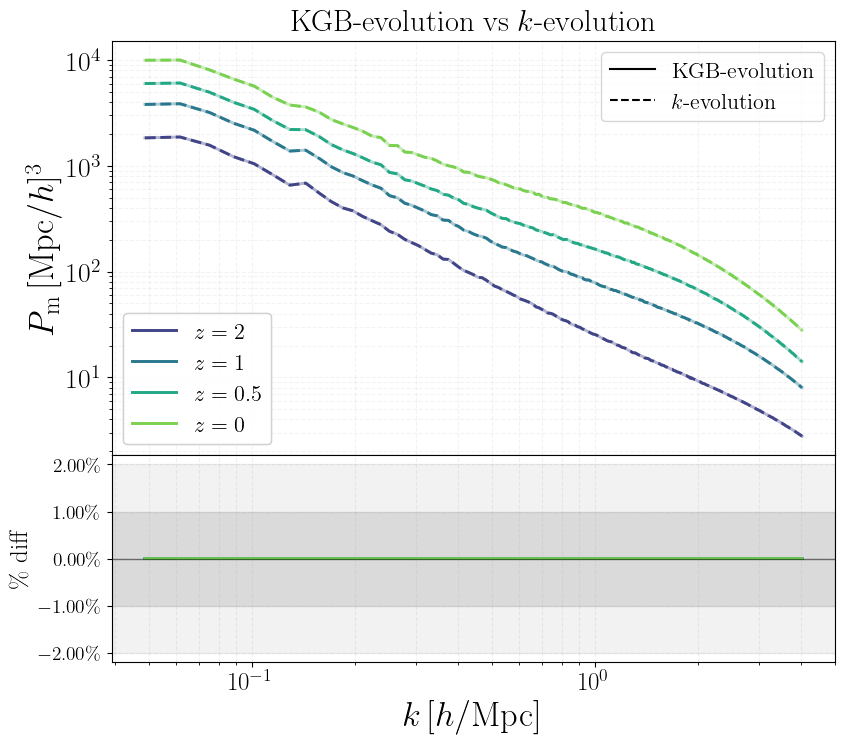

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator, PercentFormatter
import seaborn as sns

# Global plot settings
plt.rc("text", usetex=True)
plt.rc("font", family="serif", size=25)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)


# === Your data dicts ===
k_zp           = dict(zip(z, final['k']))
deltam_kgb_zp   = dict(zip(z, final['delta']))
deltam_kess_zp  = dict(zip(z_kess, final_kess['delta']))



# === Panels definition (same as before) ===
panels = [
    (
        r" KGB-evolution vs $k$‐evolution ",
        lambda zz: deltam_kgb_zp[zz],
        lambda zz: deltam_kess_zp[zz],
    )
]

# === Figure with GridSpec for main + inset stacked ===
fig = plt.figure(figsize=(9, 8))
gs  = fig.add_gridspec(len(panels)*3, 1, hspace=0.0)  
# 3 "rows" per panel → top 2 for main, bottom 1 for inset (ratio 2:1)

colors = sns.color_palette("viridis", len(target_z)).as_hex()
start_ind = 0

for i, (title, get_kgb, get_kess) in enumerate(panels):
    # Main spectrum axis
    ax_main = fig.add_subplot(gs[i*3:i*3+2, 0])   # takes 2/3 of space
    # Relative difference axis
    ax_rel  = fig.add_subplot(gs[i*3+2, 0], sharex=ax_main)  # takes 1/3
    
    # === Main curves ===
    for color, z_val in zip(colors, target_z):
        k_vals = k_zp[z_val]
        P_kgb  = get_kgb(z_val)
        P_kess = get_kess(z_val)

        ax_main.plot(k_vals[start_ind:], P_kgb[start_ind:], "-",
                     color=color, linewidth=2.1,alpha = 0.4,label=rf"$z={z_val}$")
        ax_main.plot(k_vals[start_ind:], P_kess[start_ind:], "--",
                      color=color, linewidth=2.1)

        # Relative difference
        rel = (P_kgb - P_kess) / P_kess
        ax_rel.plot(k_vals[start_ind:], rel[start_ind:], color=color, linewidth=1.8)

    # === Main formatting ===
    ax_main.set_xscale("log")
    ax_main.set_yscale("log")
    ax_main.set_title(title, fontsize=22, pad=8)
    ax_main.set_ylabel(r"$P_{\mathrm{m}}\,[\mathrm{Mpc}/h]^3$", fontsize=25)
    ax_main.grid(True, which="both", linestyle="--", alpha=0.15)

    ax_main.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2,10), numticks=12))
    ax_main.yaxis.set_major_locator(LogLocator(numticks=15))

    # === Relative difference formatting ===
    ax_rel.axhline(0.0, color="k", linewidth=1.0, alpha=0.5)
    ax_rel.set_xscale("log")
    ax_rel.set_ylabel(r"\% diff", fontsize=18)
    ax_rel.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    ax_rel.grid(True, which="both", linestyle="--", alpha=0.2)
    ax_rel.tick_params(axis="x", labelsize=18)
    ax_rel.tick_params(axis="y", labelsize=14)
    
    # === Add grey bands for 1% and 2% ===
    ax_rel.axhspan(-0.01, 0.01, color="grey", alpha=0.2)  # ±1%
    ax_rel.axhspan(-0.02, 0.02, color="grey", alpha=0.1)  # ±2%

    # === Only bottom panel gets the xlabel ===
    ax_rel.set_xlabel(r"$k\,[h/\mathrm{Mpc}]$", fontsize=25)

    # === Legends on main plot ===
    style_handles = [
        Line2D([0], [0], linestyle='-',  color='black'),
        Line2D([0], [0], linestyle='--', color='black')
    ]
    style_labels = ["KGB-evolution", r"$k$-evolution"]

    style_leg = ax_main.legend(
        handles=style_handles,
        labels=style_labels,
        loc="upper right",
        fontsize=16
    )
    ax_main.add_artist(style_leg)

    red_leg = ax_main.legend(
        loc="lower left",
        fontsize=16
    )
    
    # restore full opacity in legend only
    for lh in red_leg.get_lines():
        lh.set_alpha(1)
        
    ax_main.add_artist(red_leg)

fig.tight_layout()
plt.show()


# $\Phi$ power spectrum

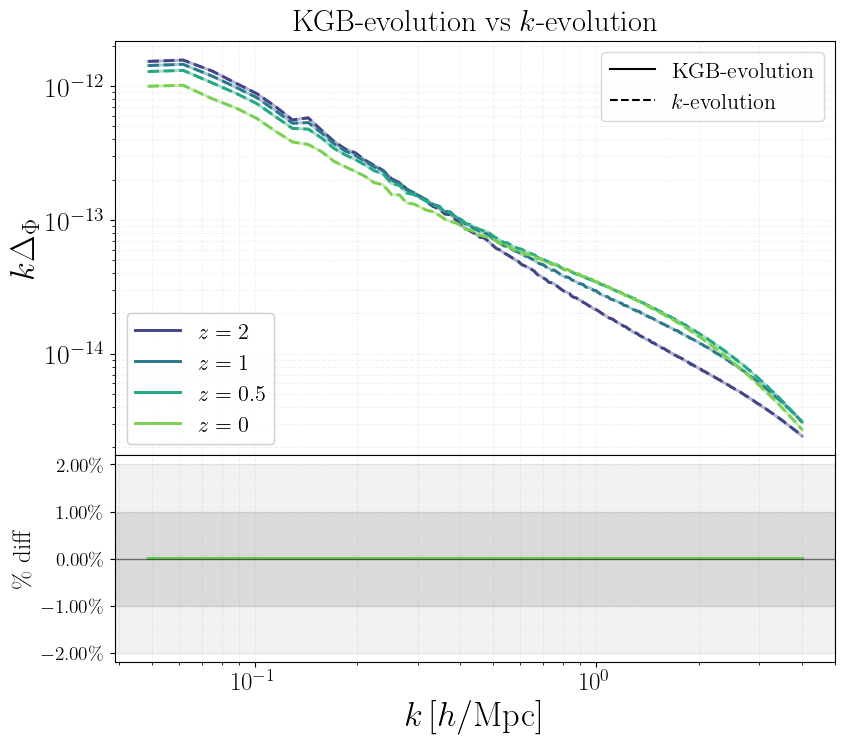

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator, PercentFormatter
import seaborn as sns


# === Your data dicts ===
k_zp           = dict(zip(z, final['k']))
phi_kgb_zp   = dict(zip(z, final['phi']))
phi_kess_zp  = dict(zip(z_kess, final_kess['phi']))



# === Panels definition (same as before) ===
panels = [
    (
        r" KGB-evolution vs $k$‐evolution ",
        lambda zz: phi_kgb_zp[zz],
        lambda zz: phi_kess_zp[zz],
    )
]

# === Figure with GridSpec for main + inset stacked ===
fig = plt.figure(figsize=(9, 8))
gs  = fig.add_gridspec(len(panels)*3, 1, hspace=0.0)  
# 3 "rows" per panel → top 2 for main, bottom 1 for inset (ratio 2:1)

colors = sns.color_palette("viridis", len(target_z)).as_hex()
start_ind = 0

for i, (title, get_kgb, get_kess) in enumerate(panels):
    # Main spectrum axis
    ax_main = fig.add_subplot(gs[i*3:i*3+2, 0])   # takes 2/3 of space
    # Relative difference axis
    ax_rel  = fig.add_subplot(gs[i*3+2, 0], sharex=ax_main)  # takes 1/3
    
    # === Main curves ===
    for color, z_val in zip(colors, target_z):
        k_vals = k_zp[z_val]
        P_kgb  = (k_vals*h)*get_kgb(z_val)
        P_kess = (k_vals*h)*get_kess(z_val)
        
        ax_main.plot(k_vals[start_ind:], P_kess[start_ind:], "--"
             , color=color, linewidth=2.1,)

        ax_main.plot(k_vals[start_ind:], P_kgb[start_ind:], "-",label=rf"$z={z_val}$",
                     color=color, linewidth=2.1,alpha = 0.4)

        # Relative difference
        rel = (P_kgb - P_kess) / P_kess
        ax_rel.plot(k_vals[start_ind:], rel[start_ind:], color=color, linewidth=1.8)

    # === Main formatting ===
    ax_main.set_xscale("log")
    ax_main.set_yscale("log")
    ax_main.set_title(title, fontsize=22, pad=8)
    ax_main.set_ylabel(r"$k \Delta_\Phi$", fontsize=25)
    ax_main.grid(True, which="both", linestyle="--", alpha=0.15)

    ax_main.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2,10), numticks=12))
    ax_main.yaxis.set_major_locator(LogLocator(numticks=15))

    # === Relative difference formatting ===
    ax_rel.axhline(0.0, color="k", linewidth=1.0, alpha=0.5)
    ax_rel.set_xscale("log")
    ax_rel.set_ylabel(r"\% diff", fontsize=18)
    ax_rel.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    ax_rel.grid(True, which="both", linestyle="--", alpha=0.2)
    ax_rel.tick_params(axis="x", labelsize=18)
    ax_rel.tick_params(axis="y", labelsize=14)
    
    # === Add grey bands for 1% and 2% ===
    ax_rel.axhspan(-0.01, 0.01, color="grey", alpha=0.2)  # ±1%
    ax_rel.axhspan(-0.02, 0.02, color="grey", alpha=0.1)  # ±2%

    # === Only bottom panel gets the xlabel ===
    ax_rel.set_xlabel(r"$k\,[h/\mathrm{Mpc}]$", fontsize=25)

    # === Legends on main plot ===
    style_handles = [
        Line2D([0], [0], linestyle='-',  color='black'),
        Line2D([0], [0], linestyle='--', color='black')
    ]
    style_labels = ["KGB-evolution", r"$k$-evolution"]

    style_leg = ax_main.legend(
        handles=style_handles,
        labels=style_labels,
        loc="upper right",
        fontsize=16
    )
    ax_main.add_artist(style_leg)

    red_leg = ax_main.legend(
        loc="lower left",
        fontsize=16
    )
    
        
    # restore full opacity in legend only
    for lh in red_leg.get_lines():
        lh.set_alpha(1)
        
    ax_main.add_artist(red_leg)

fig.tight_layout()
plt.show()


# Dark energy power spectrum

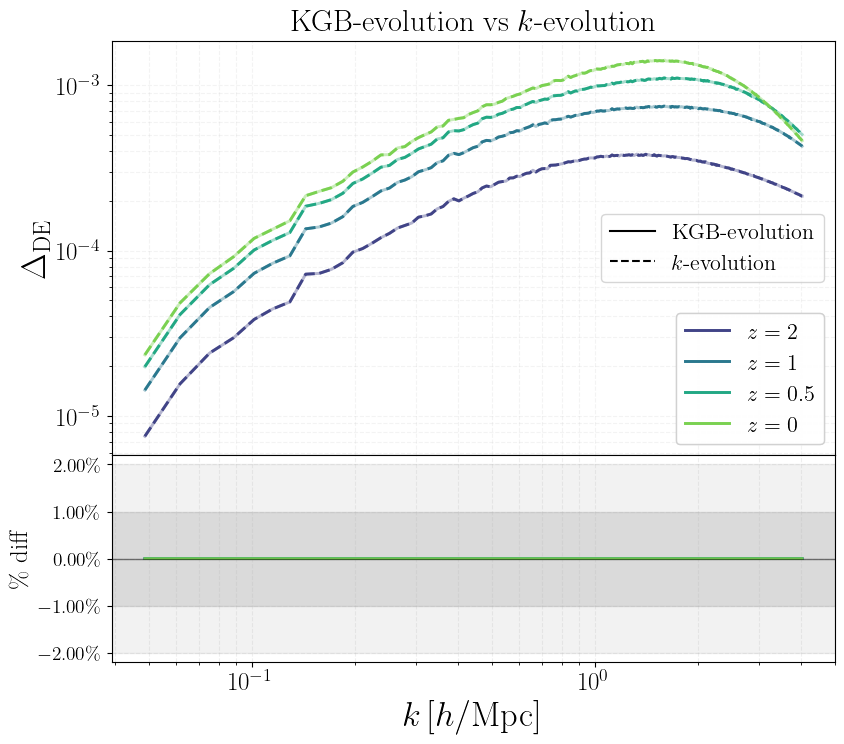

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator, PercentFormatter
import seaborn as sns


# === Your data dicts ===
k_zp           = dict(zip(z, final['k']))
delta_kgb_zp   = dict(zip(z, final['delta_kgb']))
delta_kess_zp  = dict(zip(z_kess, final_kess['delta_kess']))



# === Panels definition (same as before) ===
panels = [
    (
        r" KGB-evolution vs $k$‐evolution ",
        lambda zz: delta_kgb_zp[zz],
        lambda zz: delta_kess_zp[zz],
    )
]

# === Figure with GridSpec for main + inset stacked ===
fig = plt.figure(figsize=(9, 8))
gs  = fig.add_gridspec(len(panels)*3, 1, hspace=0.0)  
# 3 "rows" per panel → top 2 for main, bottom 1 for inset (ratio 2:1)

colors = sns.color_palette("viridis", len(target_z)).as_hex()
start_ind = 0

for i, (title, get_kgb, get_kess) in enumerate(panels):
    # Main spectrum axis
    ax_main = fig.add_subplot(gs[i*3:i*3+2, 0])   # takes 2/3 of space
    # Relative difference axis
    ax_rel  = fig.add_subplot(gs[i*3+2, 0], sharex=ax_main)  # takes 1/3
    
    # === Main curves ===
    for color, z_val in zip(colors, target_z):
        k_vals = k_zp[z_val]
        P_kgb  = get_kgb(z_val)
        P_kess = get_kess(z_val)
        
        ax_main.plot(k_vals[start_ind:], P_kess[start_ind:], "--",
             color=color, linewidth=2.1)

        ax_main.plot(k_vals[start_ind:], P_kgb[start_ind:], "-",
                     color=color,label=rf"$z={z_val}$", linewidth=2.1, alpha = 0.4)


        # Relative difference
        rel = (P_kgb - P_kess) / P_kess
        ax_rel.plot(k_vals[start_ind:], rel[start_ind:], color=color, linewidth=1.8)

    # === Main formatting ===
    ax_main.set_xscale("log")
    ax_main.set_yscale("log")
    ax_main.set_title(title, fontsize=22, pad=8)
    ax_main.set_ylabel(r"$\Delta_\mathrm{DE}$", fontsize=25)
    ax_main.grid(True, which="both", linestyle="--", alpha=0.15)
    ax_main.tick_params(which="both", labelsize=18)

    ax_main.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2,10), numticks=12))
    ax_main.yaxis.set_major_locator(LogLocator(numticks=15))

    # === Relative difference formatting ===
    ax_rel.axhline(0.0, color="k", linewidth=1.0, alpha=0.5)
    ax_rel.set_xscale("log")
    ax_rel.set_ylabel(r"\% diff", fontsize=18)
    ax_rel.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    ax_rel.grid(True, which="both", linestyle="--", alpha=0.2)
    ax_rel.tick_params(axis="x", labelsize=18)
    ax_rel.tick_params(axis="y", labelsize=14)
    
    # === Add grey bands for 1% and 2% ===
    ax_rel.axhspan(-0.01, 0.01, color="grey", alpha=0.2)  # ±1%
    ax_rel.axhspan(-0.02, 0.02, color="grey", alpha=0.1)  # ±2%
    

    # === Only bottom panel gets the xlabel ===
    ax_rel.set_xlabel(r"$k\,[h/\mathrm{Mpc}]$", fontsize=25)

    # === Legends on main plot ===
    style_handles = [
        Line2D([0], [0], linestyle='-',  color='black'),
        Line2D([0], [0], linestyle='--', color='black')
    ]
    style_labels = ["KGB-evolution", r"$k$-evolution"]

    style_leg = ax_main.legend(
        handles=style_handles,
        labels=style_labels,
        loc="center right",
        fontsize=16
    )
    ax_main.add_artist(style_leg)

    red_leg = ax_main.legend(
        loc="lower right",
        fontsize=16
    )
    
    # restore full opacity in legend only
    for lh in red_leg.get_lines():
        lh.set_alpha(1)
        
    ax_main.add_artist(red_leg)

fig.tight_layout()
plt.show()



# $B_i$

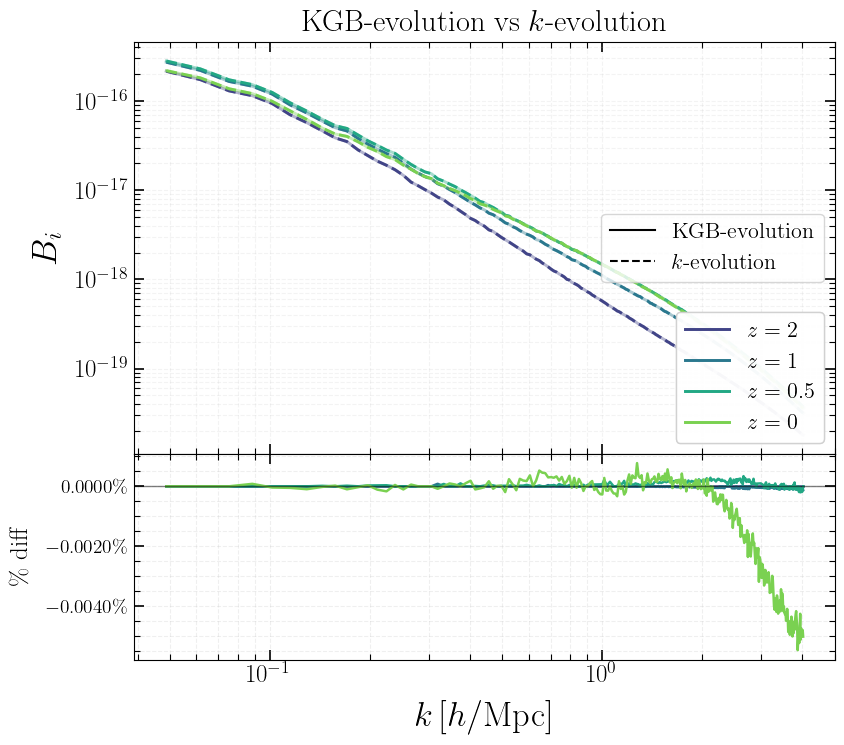

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator, PercentFormatter
import seaborn as sns


# === Your data dicts ===
k_zp           = dict(zip(z, final['k']))
B_kgb_zp   = dict(zip(z, final['B']))
B_kess_zp  = dict(zip(z_kess, final_kess['B']))



# === Panels definition (same as before) ===
panels = [
    (
        r" KGB-evolution vs $k$‐evolution ",
        lambda zz: B_kgb_zp[zz],
        lambda zz: B_kess_zp[zz],
    )
]

# === Figure with GridSpec for main + inset stacked ===
fig = plt.figure(figsize=(9, 8))
gs  = fig.add_gridspec(len(panels)*3, 1, hspace=0.0)  
# 3 "rows" per panel → top 2 for main, bottom 1 for inset (ratio 2:1)

colors = sns.color_palette("viridis", len(target_z)).as_hex()
start_ind = 0

for i, (title, get_kgb, get_kess) in enumerate(panels):
    # Main spectrum axis
    ax_main = fig.add_subplot(gs[i*3:i*3+2, 0])   # takes 2/3 of space
    # Relative difference axis
    ax_rel  = fig.add_subplot(gs[i*3+2, 0], sharex=ax_main)  # takes 1/3
    
    # === Main curves ===
    for color, z_val in zip(colors, target_z):
        k_vals = k_zp[z_val]
        P_kgb  = get_kgb(z_val)
        P_kess = get_kess(z_val)
        
        ax_main.plot(k_vals[start_ind:], P_kess[start_ind:], "--",
             color=color, linewidth=2.1)

        ax_main.plot(k_vals[start_ind:], P_kgb[start_ind:], "-",
                     color=color,label=rf"$z={z_val}$", linewidth=2.1, alpha = 0.4)


        # Relative difference
        rel = (P_kgb - P_kess) / P_kess
        ax_rel.plot(k_vals[start_ind:], rel[start_ind:], color=color, linewidth=1.8)

    # === Main formatting ===
    ax_main.set_xscale("log")
    ax_main.set_yscale("log")
    ax_main.set_title(title, fontsize=22, pad=8)
    ax_main.set_ylabel(r"$B_i$", fontsize=25)
    ax_main.grid(True, which="both", linestyle="--", alpha=0.15)
    ax_main.tick_params(which="both", labelsize=18)

    ax_main.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2,10), numticks=12))
    ax_main.yaxis.set_major_locator(LogLocator(numticks=15))

    # === Relative difference formatting ===
    ax_rel.axhline(0.0, color="k", linewidth=1.0, alpha=0.5)
    ax_rel.set_xscale("log")
    ax_rel.set_ylabel(r"\% diff", fontsize=18)
    ax_rel.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    ax_rel.grid(True, which="both", linestyle="--", alpha=0.2)
    ax_rel.tick_params(axis="x", labelsize=18)
    ax_rel.tick_params(axis="y", labelsize=14)
    
    # === Add grey bands for 1% and 2% ===
#     ax_rel.axhspan(-0.01, 0.01, color="grey", alpha=0.2)  # ±1%
#     ax_rel.axhspan(-0.02, 0.02, color="grey", alpha=0.1)  # ±2%
    

    # === Only bottom panel gets the xlabel ===
    ax_rel.set_xlabel(r"$k\,[h/\mathrm{Mpc}]$", fontsize=25)

    # === Legends on main plot ===
    style_handles = [
        Line2D([0], [0], linestyle='-',  color='black'),
        Line2D([0], [0], linestyle='--', color='black')
    ]
    style_labels = ["KGB-evolution", r"$k$-evolution"]

    style_leg = ax_main.legend(
        handles=style_handles,
        labels=style_labels,
        loc="center right",
        fontsize=16
    )
    ax_main.add_artist(style_leg)

    red_leg = ax_main.legend(
        loc="lower right",
        fontsize=16
    )
    
    # restore full opacity in legend only
    for lh in red_leg.get_lines():
        lh.set_alpha(1)
        
    ax_main.add_artist(red_leg)

fig.tight_layout()
plt.show()

# $h_{ij}$

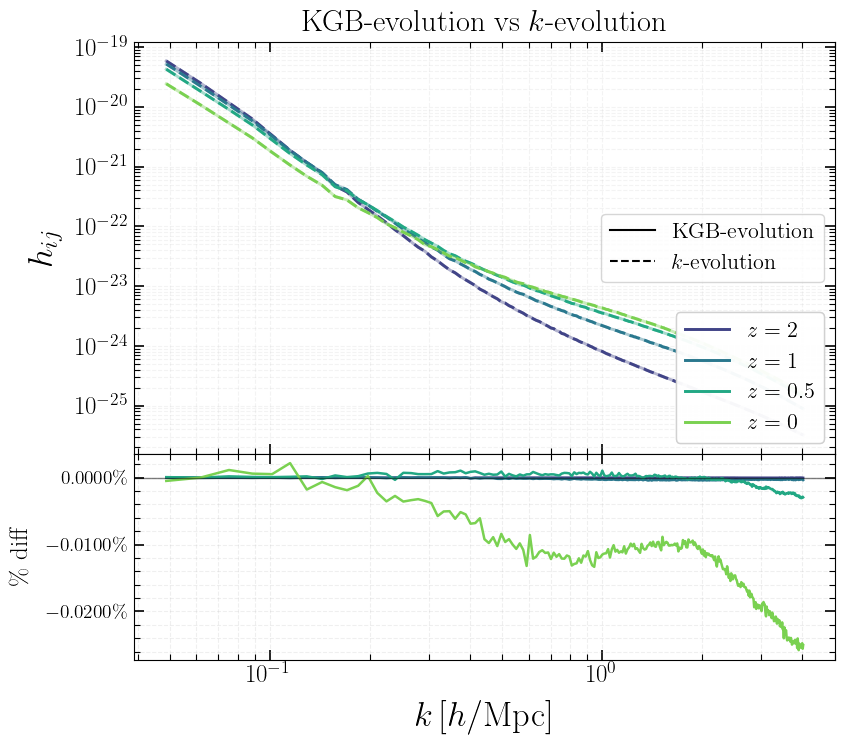

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator, PercentFormatter
import seaborn as sns


# === Your data dicts ===
k_zp           = dict(zip(z, final['k']))
h_kgb_zp   = dict(zip(z, final['hij']))
h_kess_zp  = dict(zip(z_kess, final_kess['hij']))



# === Panels definition (same as before) ===
panels = [
    (
        r" KGB-evolution vs $k$‐evolution ",
        lambda zz: h_kgb_zp[zz],
        lambda zz: h_kess_zp[zz],
    )
]

# === Figure with GridSpec for main + inset stacked ===
fig = plt.figure(figsize=(9, 8))
gs  = fig.add_gridspec(len(panels)*3, 1, hspace=0.0)  
# 3 "rows" per panel → top 2 for main, bottom 1 for inset (ratio 2:1)

colors = sns.color_palette("viridis", len(target_z)).as_hex()
start_ind = 0

for i, (title, get_kgb, get_kess) in enumerate(panels):
    # Main spectrum axis
    ax_main = fig.add_subplot(gs[i*3:i*3+2, 0])   # takes 2/3 of space
    # Relative difference axis
    ax_rel  = fig.add_subplot(gs[i*3+2, 0], sharex=ax_main)  # takes 1/3
    
    # === Main curves ===
    for color, z_val in zip(colors, target_z):
        k_vals = k_zp[z_val]
        P_kgb  = get_kgb(z_val)
        P_kess = get_kess(z_val)
        
        ax_main.plot(k_vals[start_ind:], P_kess[start_ind:], "--",
             color=color, linewidth=2.1)

        ax_main.plot(k_vals[start_ind:], P_kgb[start_ind:], "-",
                     color=color,label=rf"$z={z_val}$", linewidth=2.1, alpha = 0.4)


        # Relative difference
        rel = (P_kgb - P_kess) / P_kess
        ax_rel.plot(k_vals[start_ind:], rel[start_ind:], color=color, linewidth=1.8)

    # === Main formatting ===
    ax_main.set_xscale("log")
    ax_main.set_yscale("log")
    ax_main.set_title(title, fontsize=22, pad=8)
    ax_main.set_ylabel(r"$h_{ij}$", fontsize=25)
    ax_main.grid(True, which="both", linestyle="--", alpha=0.15)
    ax_main.tick_params(which="both", labelsize=18)

    ax_main.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2,10), numticks=12))
    ax_main.yaxis.set_major_locator(LogLocator(numticks=15))

    # === Relative difference formatting ===
    ax_rel.axhline(0.0, color="k", linewidth=1.0, alpha=0.5)
    ax_rel.set_xscale("log")
    ax_rel.set_ylabel(r"\% diff", fontsize=18)
    ax_rel.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    ax_rel.grid(True, which="both", linestyle="--", alpha=0.2)
    ax_rel.tick_params(axis="x", labelsize=18)
    ax_rel.tick_params(axis="y", labelsize=14)
    
    # === Add grey bands for 1% and 2% ===
#     ax_rel.axhspan(-0.01, 0.01, color="grey", alpha=0.2)  # ±1%
#     ax_rel.axhspan(-0.02, 0.02, color="grey", alpha=0.1)  # ±2%
    

    # === Only bottom panel gets the xlabel ===
    ax_rel.set_xlabel(r"$k\,[h/\mathrm{Mpc}]$", fontsize=25)

    # === Legends on main plot ===
    style_handles = [
        Line2D([0], [0], linestyle='-',  color='black'),
        Line2D([0], [0], linestyle='--', color='black')
    ]
    style_labels = ["KGB-evolution", r"$k$-evolution"]

    style_leg = ax_main.legend(
        handles=style_handles,
        labels=style_labels,
        loc="center right",
        fontsize=16
    )
    ax_main.add_artist(style_leg)

    red_leg = ax_main.legend(
        loc="lower right",
        fontsize=16
    )
    
    # restore full opacity in legend only
    for lh in red_leg.get_lines():
        lh.set_alpha(1)
        
    ax_main.add_artist(red_leg)

fig.tight_layout()
plt.show()

/tmp/ipykernel_26460/1393484852.py:93: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



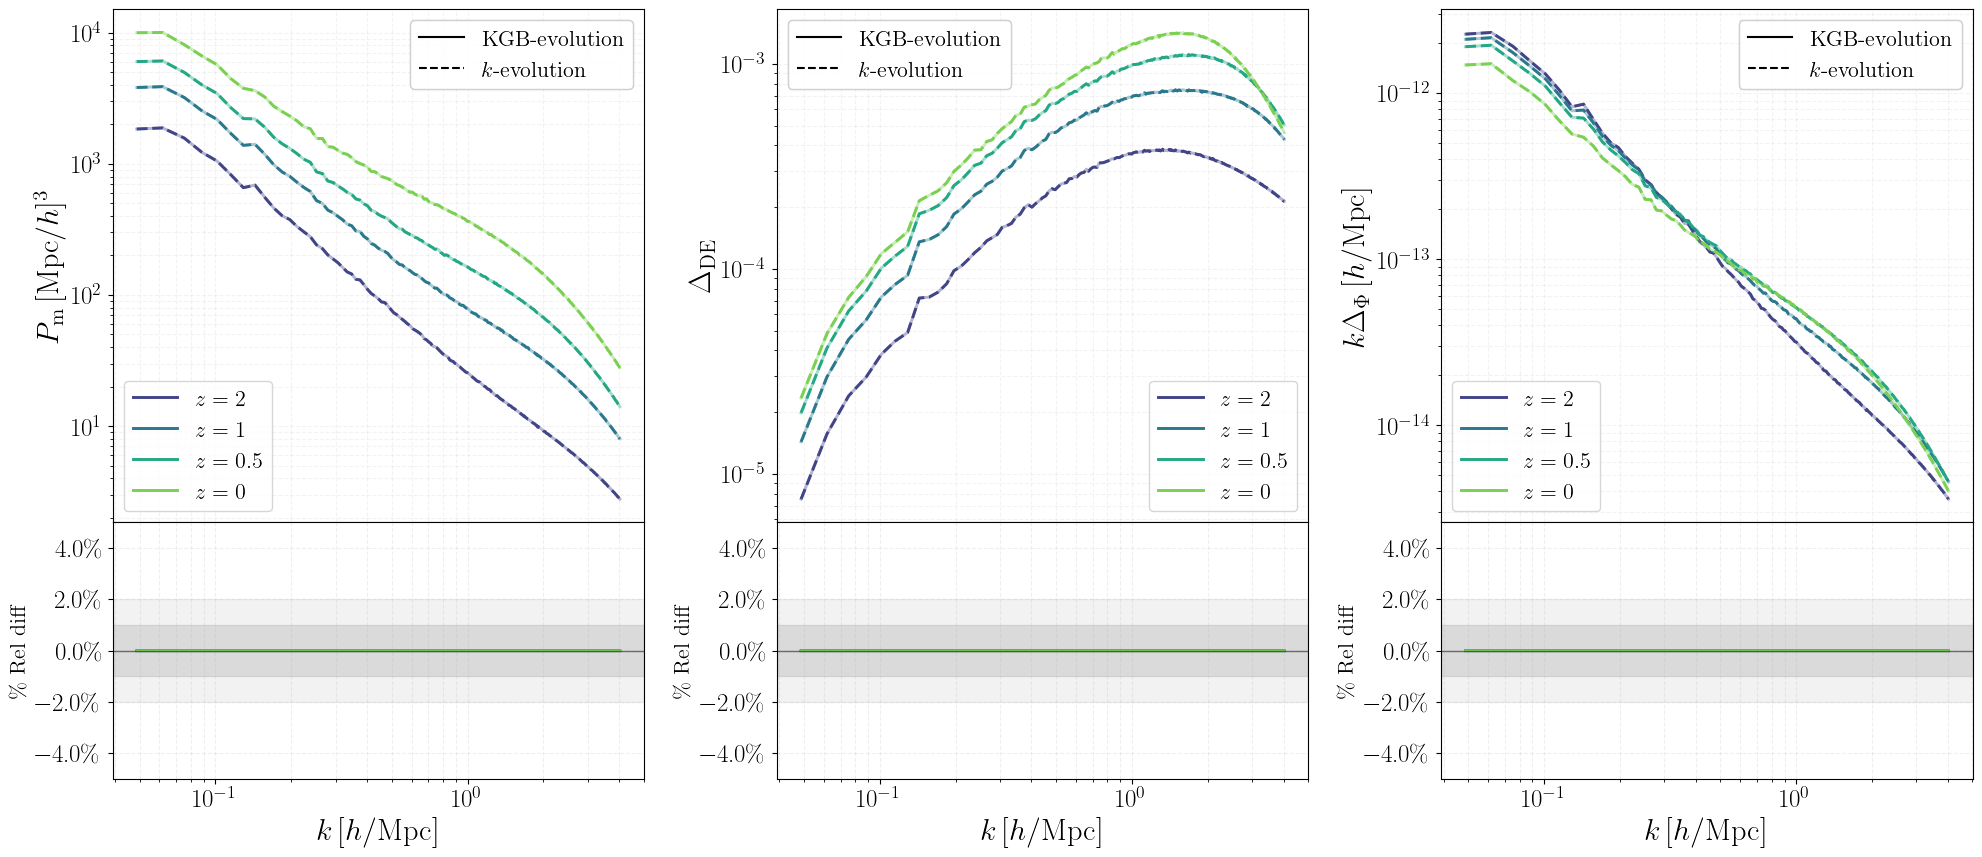

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator, PercentFormatter
import seaborn as sns

# === Data dicts (as before) ===
k_zp           = dict(zip(z, final['k']))
deltam_kgb_zp  = dict(zip(z, final['delta']))
deltam_kess_zp = dict(zip(z_kess, final_kess['delta']))

delta_kgb_zp   = dict(zip(z, final['delta_kgb']))
delta_kess_zp  = dict(zip(z_kess, final_kess['delta_kess']))

phi_kgb_zp     = dict(zip(z, final['phi']))
phi_kess_zp    = dict(zip(z_kess, final_kess['phi']))

# === Panels: (getter_kgb, getter_kess, ylabel) ===
panels = [
    (lambda zz: deltam_kgb_zp[zz],  lambda zz: deltam_kess_zp[zz],  r"$P_{\mathrm{m}}\,[\mathrm{Mpc}/h]^3$"),
    (lambda zz: delta_kgb_zp[zz],   lambda zz: delta_kess_zp[zz],   r"$\Delta_\mathrm{DE}$"),
    (lambda zz: (k_zp[zz])*phi_kgb_zp[zz], lambda zz: (k_zp[zz])*phi_kess_zp[zz], r"$k\Delta_\Phi \,[h/\mathrm{Mpc}]$")
]

# === Figure: outer 1×3 grid; each column gets its own (main + inset) stack ===
fig = plt.figure(figsize=(24, 10))
outer = fig.add_gridspec(nrows=1, ncols=3, wspace=0.25)

colors = sns.color_palette("viridis", len(target_z)).as_hex()
start_ind = 0

for j, (get_kgb, get_kess, ylabel) in enumerate(panels):
    # Sub-grid inside this column: 2 rows (ratio 2:1), shared x
    sub = outer[j].subgridspec(2, 1, height_ratios=[2, 1], hspace=0.0)
    ax_main = fig.add_subplot(sub[0])
    ax_rel  = fig.add_subplot(sub[1], sharex=ax_main)

    for color, z_val in zip(colors, target_z):
        k_vals = k_zp[z_val]
        P_kgb  = get_kgb(z_val)
        P_kess = get_kess(z_val)

        # Main curves
        ax_main.plot(k_vals[start_ind:], P_kess[start_ind:], "--", color=color, linewidth=2.1)
        ax_main.plot(k_vals[start_ind:], P_kgb[start_ind:],  "-",  color=color,
                     linewidth=2.1, alpha=0.4, label=rf"$z={z_val}$")

        # Relative difference (attached inset below)
        rel = (P_kgb - P_kess) / P_kess
        ax_rel.plot(k_vals[start_ind:], rel[start_ind:], color=color, linewidth=1.8)

    # === Main formatting ===
    ax_main.set_xscale("log")
    ax_main.set_yscale("log")
    ax_main.set_ylabel(ylabel, fontsize=22)
    ax_main.grid(True, which="both", linestyle="--", alpha=0.15)
    ax_main.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2,10), numticks=12))
    ax_main.yaxis.set_major_locator(LogLocator(numticks=15))
    ax_main.tick_params(axis="x", labelsize=18)
    ax_main.tick_params(axis="y", labelsize=18)


    # === Inset (relative) formatting ===
    ax_rel.axhline(0.0, color="k", linewidth=1.0, alpha=0.5)
    ax_rel.set_xscale("log")
    ax_rel.set_ylabel(r"\% Rel diff", fontsize=16)
    ax_rel.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    ax_rel.grid(True, which="both", linestyle="--", alpha=0.2)
    ax_rel.tick_params(axis="x", labelsize=18)
    ax_rel.tick_params(axis="y", labelsize=18)
    ax_rel.axhspan(-0.01, 0.01, color="grey", alpha=0.2)  # ±1%
    ax_rel.axhspan(-0.02, 0.02, color="grey", alpha=0.1)  # ±2%
    ax_rel.set_xlabel(r"$k\,[h/\mathrm{Mpc}]$", fontsize=22)
    ax_rel.set_ylim(-0.05, 0.05)

    # === Legends on main ===
    red_loc = "lower right" if j == 1 else "lower left"
    z_leg = ax_main.legend(loc=red_loc, fontsize=16)
    for lh in z_leg.get_lines():
        lh.set_alpha(1)
    ax_main.add_artist(z_leg)

    style_loc = "upper left" if j == 1 else "upper right"
    style_handles = [
        Line2D([0], [0], linestyle='-',  color='black'),
        Line2D([0], [0], linestyle='--', color='black')
    ]
    style_labels = ["KGB-evolution", r"$k$-evolution"]
    style_leg = ax_main.legend(handles=style_handles, labels=style_labels,
                               loc=style_loc, fontsize=16)
    ax_main.add_artist(style_leg)

plt.tight_layout()
plt.show()


/tmp/ipykernel_26460/1208235064.py:93: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



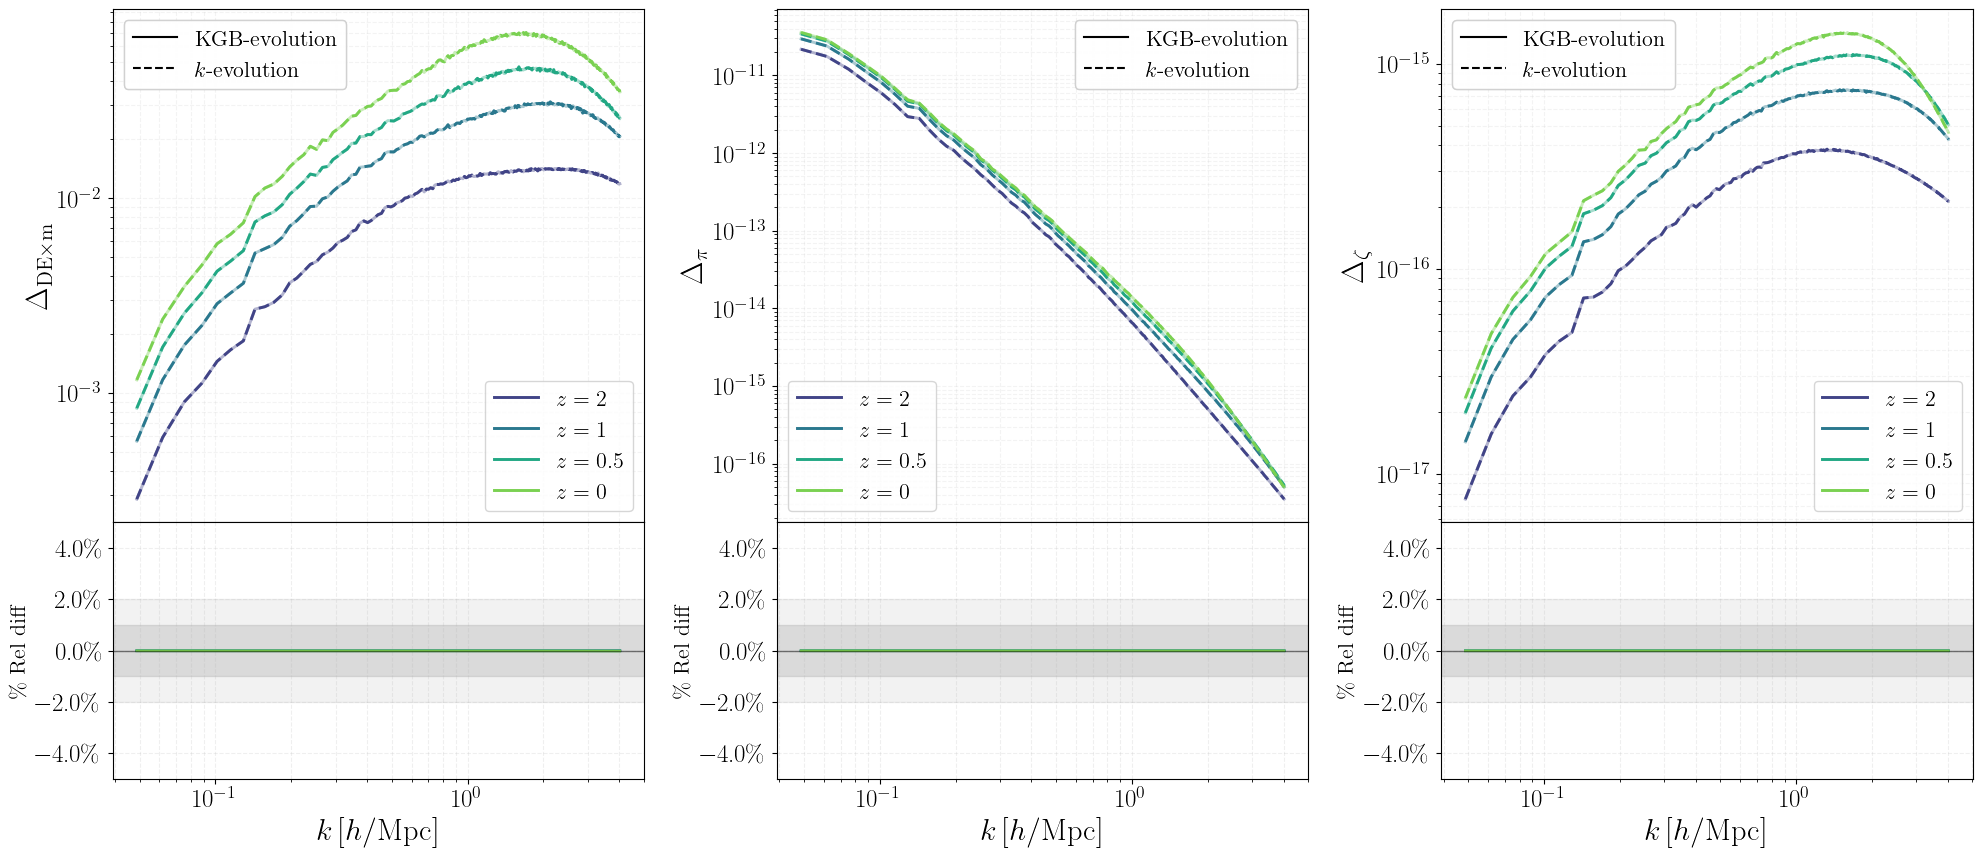

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator, PercentFormatter
import seaborn as sns

k_zp           = dict(zip(z, final['k']))
deltakgb_deltam_zp   = dict(zip(z, final['deltakgb_deltam']))
deltakess_deltam_zp  = dict(zip(z_kess, final_kess['deltakess_deltam']))

pi_k_kgb_zp   = dict(zip(z, final['pi_k']))
pi_k_kess_zp  = dict(zip(z_kess, final_kess['pi_k']))

zeta_kgb_zp   = dict(zip(z, final['zeta']))
zeta_kess_zp  = dict(zip(z_kess, final_kess['zeta']))


# === Panels: (getter_kgb, getter_kess, ylabel) ===
panels = [
    (lambda zz: deltakgb_deltam_zp[zz],  lambda zz: deltakess_deltam_zp [zz], r"$\Delta_{\mathrm{DE}\times \mathrm{m}}$"),
    (lambda zz: pi_k_kgb_zp[zz],   lambda zz: pi_k_kess_zp[zz],   r"$\Delta_\pi$"),
    (lambda zz: zeta_kgb_zp[zz], lambda zz: zeta_kess_zp[zz], r"$\Delta_\zeta$")
]

# === Figure: outer 1×3 grid; each column gets its own (main + inset) stack ===
fig = plt.figure(figsize=(24, 10))
outer = fig.add_gridspec(nrows=1, ncols=3, wspace=0.25)

colors = sns.color_palette("viridis", len(target_z)).as_hex()
start_ind = 0

for j, (get_kgb, get_kess, ylabel) in enumerate(panels):
    # Sub-grid inside this column: 2 rows (ratio 2:1), shared x
    sub = outer[j].subgridspec(2, 1, height_ratios=[2, 1], hspace=0.0)
    ax_main = fig.add_subplot(sub[0])
    ax_rel  = fig.add_subplot(sub[1], sharex=ax_main)

    for color, z_val in zip(colors, target_z):
        k_vals = k_zp[z_val]
        P_kgb  = get_kgb(z_val)
        P_kess = get_kess(z_val)

        # Main curves
        ax_main.plot(k_vals[start_ind:], P_kess[start_ind:], "--", color=color, linewidth=2.1)
        ax_main.plot(k_vals[start_ind:], P_kgb[start_ind:],  "-",  color=color,
                     linewidth=2.1, alpha=0.4, label=rf"$z={z_val}$")

        # Relative difference (attached inset below)
        rel = (P_kgb - P_kess) / P_kess
        ax_rel.plot(k_vals[start_ind:], rel[start_ind:], color=color, linewidth=1.8)

    # === Main formatting ===
    ax_main.set_xscale("log")
    ax_main.set_yscale("log")
    ax_main.set_ylabel(ylabel, fontsize=22)
    ax_main.grid(True, which="both", linestyle="--", alpha=0.15)
    ax_main.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2,10), numticks=12))
    ax_main.yaxis.set_major_locator(LogLocator(numticks=15))
    ax_main.tick_params(axis="x", labelsize=18)
    ax_main.tick_params(axis="y", labelsize=18)


    # === Inset (relative) formatting ===
    ax_rel.axhline(0.0, color="k", linewidth=1.0, alpha=0.5)
    ax_rel.set_xscale("log")
    ax_rel.set_ylabel(r"\% Rel diff", fontsize=16)
    ax_rel.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    ax_rel.grid(True, which="both", linestyle="--", alpha=0.2)
    ax_rel.tick_params(axis="x", labelsize=18)
    ax_rel.tick_params(axis="y", labelsize=18)
    ax_rel.axhspan(-0.01, 0.01, color="grey", alpha=0.2)  # ±1%
    ax_rel.axhspan(-0.02, 0.02, color="grey", alpha=0.1)  # ±2%
    ax_rel.set_ylim(-0.05, 0.05)
    ax_rel.set_xlabel(r"$k\,[h/\mathrm{Mpc}]$", fontsize=22)

    # === Legends on main ===
    red_loc = "lower left" if j == 1 else "lower right"
    z_leg = ax_main.legend(loc=red_loc, fontsize=16)
    for lh in z_leg.get_lines():
        lh.set_alpha(1)
    ax_main.add_artist(z_leg)

    style_loc = "upper right" if j == 1 else "upper left"
    style_handles = [
        Line2D([0], [0], linestyle='-',  color='black'),
        Line2D([0], [0], linestyle='--', color='black')
    ]
    style_labels = ["KGB-evolution", r"$k$-evolution"]
    style_leg = ax_main.legend(handles=style_handles, labels=style_labels,
                               loc=style_loc, fontsize=16)
    ax_main.add_artist(style_leg)

plt.tight_layout()
plt.show()


/tmp/ipykernel_140909/3908507977.py:181: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/tmp/ipykernel_140909/3908507977.py:204: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Saving figure KGBevolution_vs_kevolution


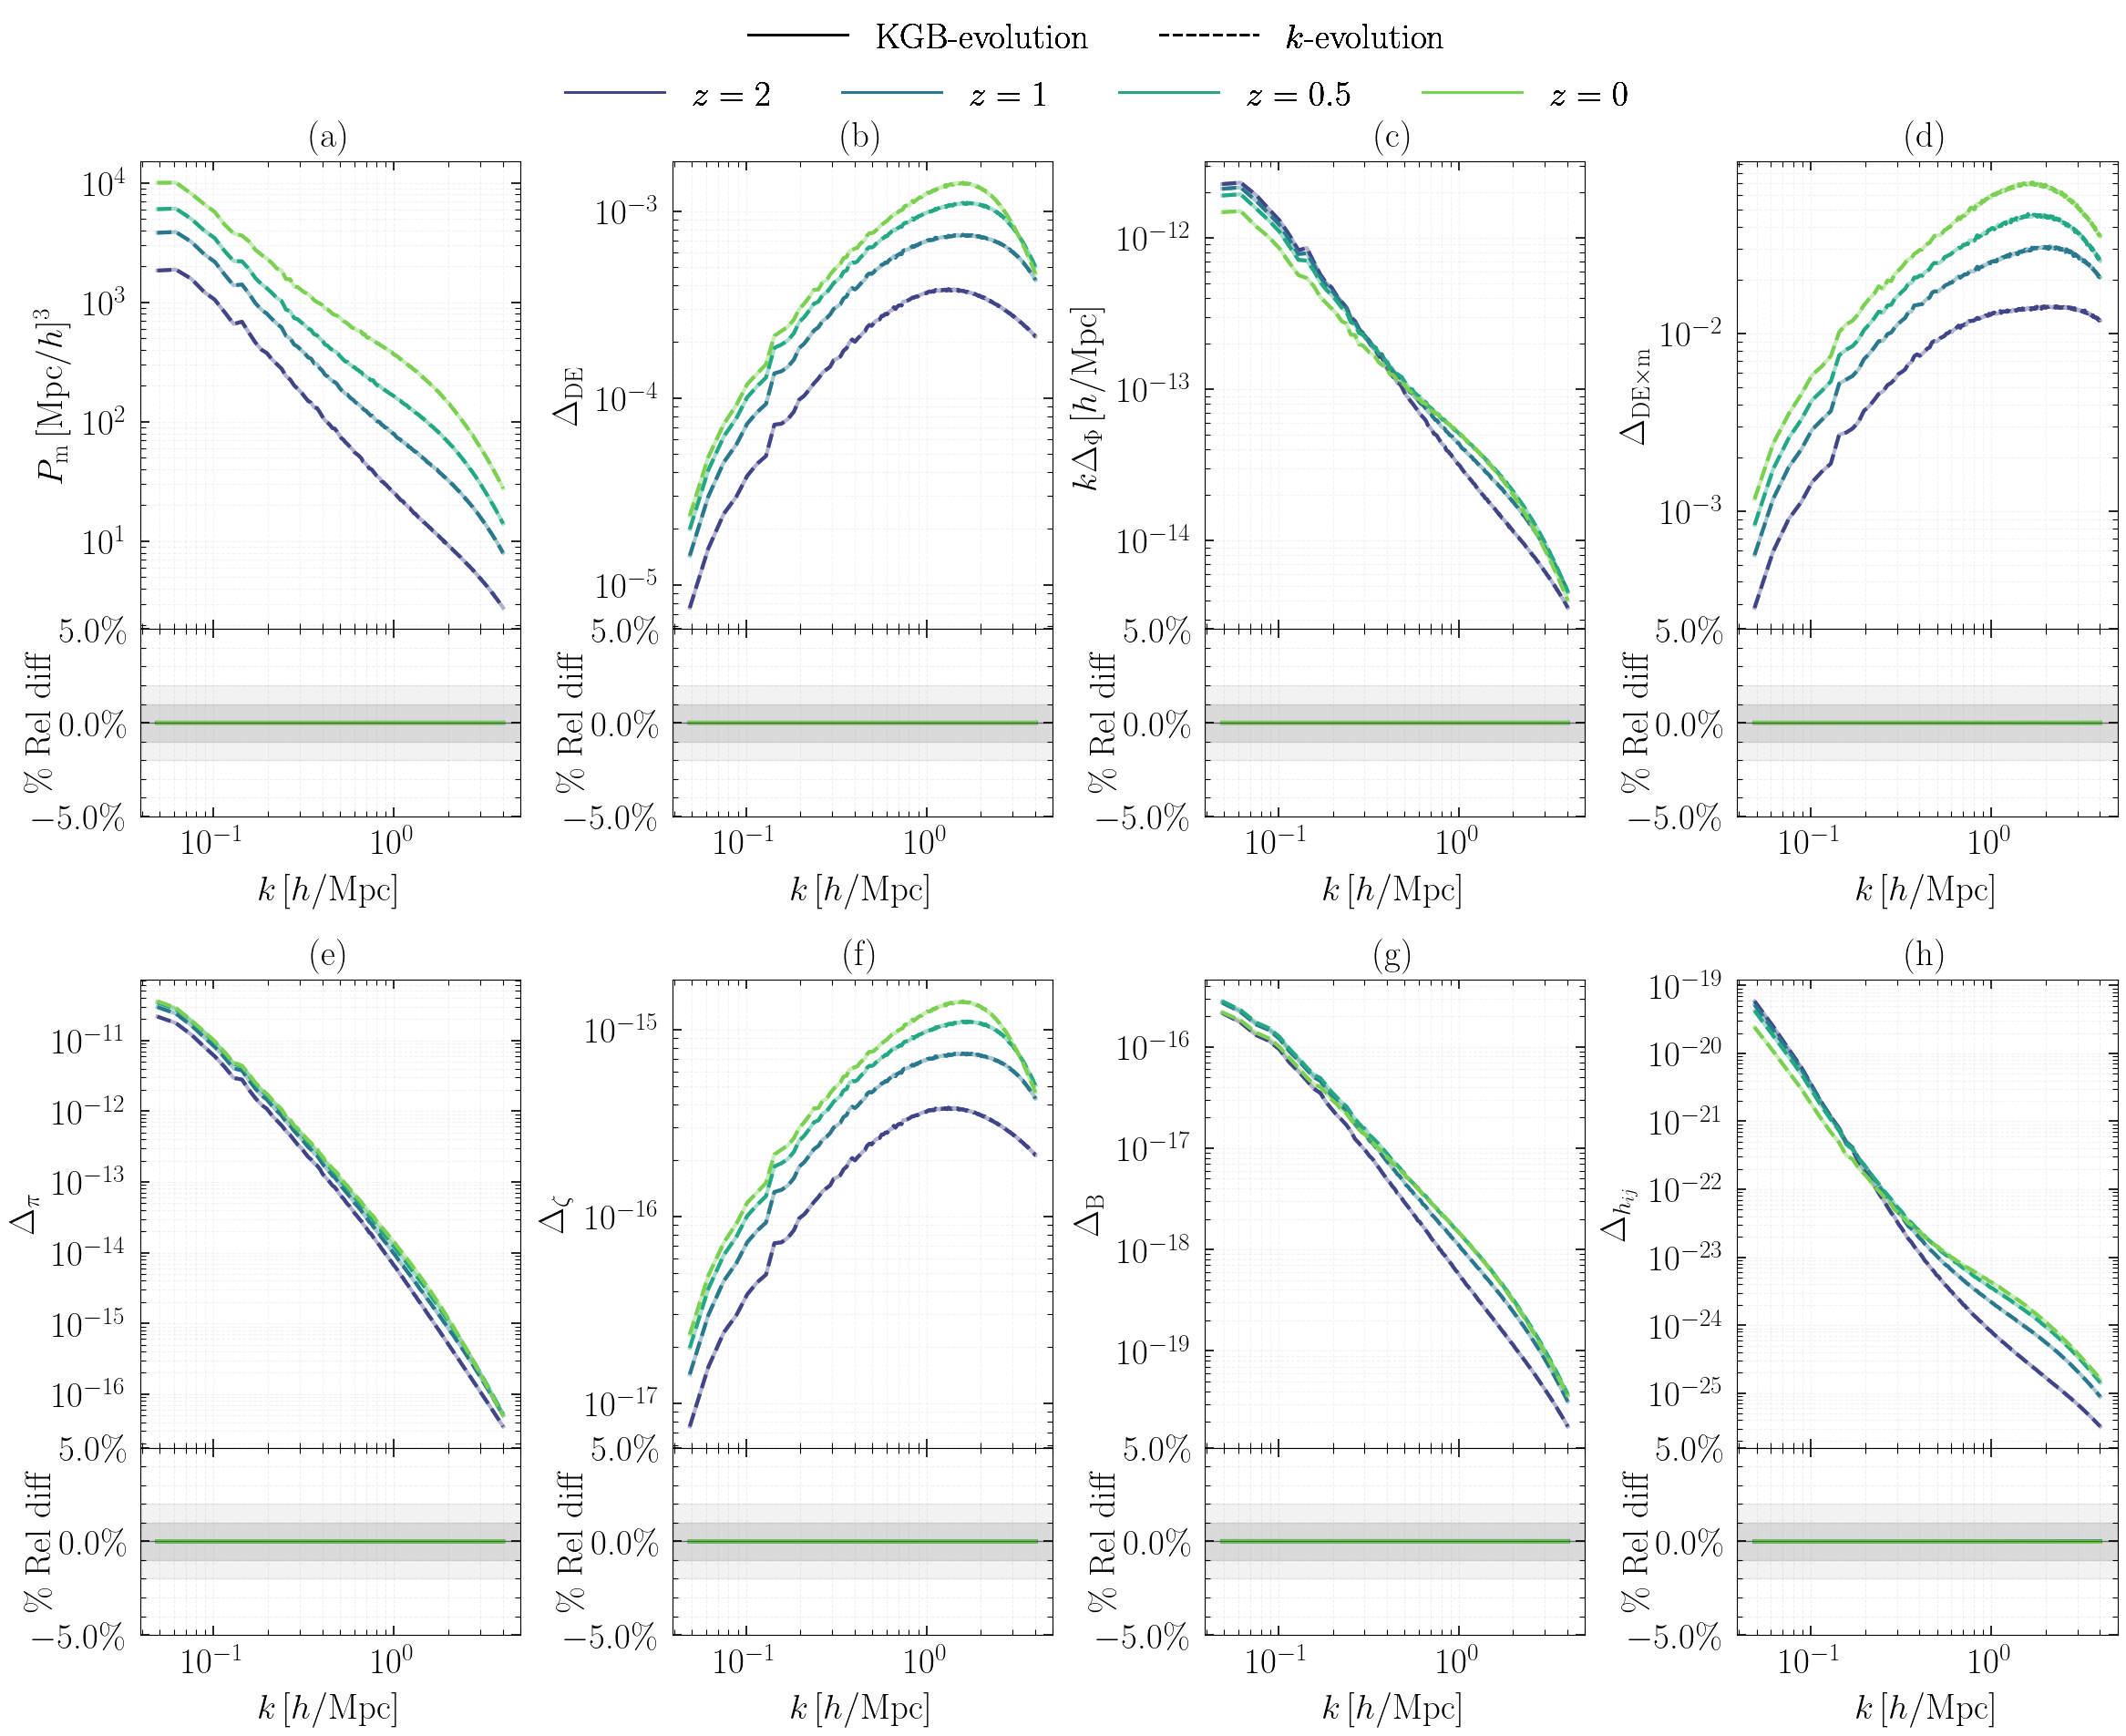

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator, PercentFormatter
import seaborn as sns
import string

LABEL_SIZE  = 32   # axis labels
TICK_SIZE   = 26   # tick labels
FONT_SIZE   = 30   # general font
LEGEND_SIZE = 25   # legend text


# === Data dicts (from your two snippets) ===
k_zp           = dict(zip(z, final['k']))

# Set 1
deltam_kgb_zp  = dict(zip(z, final['delta']))
deltam_kess_zp = dict(zip(z_kess, final_kess['delta']))

delta_kgb_zp   = dict(zip(z, final['delta_kgb']))
delta_kess_zp  = dict(zip(z_kess, final_kess['delta_kess']))

phi_kgb_zp     = dict(zip(z, final['phi']))
phi_kess_zp    = dict(zip(z_kess, final_kess['phi']))

# Set 2
deltakgb_deltam_zp   = dict(zip(z, final['deltakgb_deltam']))
deltakess_deltam_zp  = dict(zip(z_kess, final_kess['deltakess_deltam']))

pi_k_kgb_zp   = dict(zip(z, final['pi_k']))
pi_k_kess_zp  = dict(zip(z_kess, final_kess['pi_k']))

zeta_kgb_zp   = dict(zip(z, final['zeta']))
zeta_kess_zp  = dict(zip(z_kess, final_kess['zeta']))

B_kgb_zp   = dict(zip(z, final['B']))
B_kess_zp  = dict(zip(z_kess, final_kess['B']))

h_kgb_zp   = dict(zip(z, final['hij']))
h_kess_zp  = dict(zip(z_kess, final_kess['hij']))

# === Panels from set 1 (main + inset) ===
panels_1 = [
    (lambda zz: deltam_kgb_zp[zz],  lambda zz: deltam_kess_zp[zz],  r"$P_{\mathrm{m}}\,[\mathrm{Mpc}/h]^3$"),
    (lambda zz: delta_kgb_zp[zz],   lambda zz: delta_kess_zp[zz],   r"$\Delta_\mathrm{DE}$"),
    (lambda zz: (k_zp[zz]) * phi_kgb_zp[zz], lambda zz: (k_zp[zz]) * phi_kess_zp[zz], r"$k\Delta_\Phi \,[h/\mathrm{Mpc}]$")
]

# === Panels from set 2 (main + inset) ===
panels_2 = [
    (lambda zz: deltakgb_deltam_zp[zz],  lambda zz: deltakess_deltam_zp[zz], r"$\Delta_{\mathrm{DE}\times \mathrm{m}}$"),
    (lambda zz: pi_k_kgb_zp[zz],         lambda zz: pi_k_kess_zp[zz],        r"$\Delta_\pi$"),
    (lambda zz: zeta_kgb_zp[zz],         lambda zz: zeta_kess_zp[zz],        r"$\Delta_\zeta$")
]

# === Panels from set 3 (new) ===
panels_extra = [
    (lambda zz: B_kgb_zp[zz],  lambda zz: B_kess_zp[zz],  r"$\Delta_\mathrm{B}$"),
    (lambda zz: h_kgb_zp[zz],  lambda zz: h_kess_zp[zz],  r"$\Delta_{h_{ij}}$")
]

# === Concatenate into one list of 8 panels ===
panels = panels_1 + panels_2 + panels_extra

plt.rcParams.update({
    # geometry/visibility
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,

    # sizes (length in points)
    "xtick.major.size": 7.5,
    "ytick.major.size": 7.5,
    "xtick.minor.size": 4.0,
    "ytick.minor.size": 4.0,

    # widths (thickness in points)
    "xtick.major.width": 1.2,
    "ytick.major.width": 1.2,
    "xtick.minor.width": 0.8,
    "ytick.minor.width": 0.8,

    # labels (optional)
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    
    "axes.labelpad": 10

})

plt.rcParams.update({
    "legend.fontsize": 28,
})

# === Plot settings ===
plt.rc("text", usetex=True)
plt.rc("font", family="serif", size=FONT_SIZE)
plt.rc("xtick", labelsize=TICK_SIZE)
plt.rc("ytick", labelsize=TICK_SIZE)

# === New overall layout: 2 rows × 4 cols ===
rows, cols = 2, 4
fig = plt.figure(figsize=(28, 21))   # wider, less tall for 4 columns
outer = fig.add_gridspec(nrows=rows, ncols=cols, wspace=0.4, hspace=0.25)


colors = sns.color_palette("viridis", len(target_z)).as_hex()
start_ind = 0

for p_idx, (get_kgb, get_kess, ylabel) in enumerate(panels):
    r = p_idx // cols     # row index
    c = p_idx % cols      # col index


    # Sub-grid inside this cell: 2 rows (main:inset = 2:1), tiny gap so ticks don't collide
    sub = outer[r, c].subgridspec(2, 1, height_ratios=[2.5, 1], hspace=0.0)
    ax_main = fig.add_subplot(sub[0])
    ax_rel  = fig.add_subplot(sub[1], sharex=ax_main)

    # Plot data
    for color, z_val in zip(colors, target_z):
        k_vals = k_zp[z_val]
        P_kgb  = get_kgb(z_val)
        P_kess = get_kess(z_val)

        # Main curves
        ax_main.plot(k_vals[start_ind:], P_kess[start_ind:], "--", color=color, linewidth=3)
        ax_main.plot(k_vals[start_ind:], P_kgb[start_ind:],  "-",  color=color,
                     linewidth=3, alpha=0.4, label=rf"$z={z_val}$")

        # Relative difference in the attached inset
        rel = (P_kgb - P_kess) / P_kess
        ax_rel.plot(k_vals[start_ind:], rel[start_ind:], color=color, linewidth=3)

    # === Main formatting ===
    ax_main.set_xscale("log")
    ax_main.set_yscale("log")
    ax_main.set_ylabel(ylabel, fontsize=28)
    ax_main.grid(True, which="both", linestyle="--", alpha=0.15)
    ax_main.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2,10), numticks=12))
    ax_main.yaxis.set_major_locator(LogLocator(numticks=15))
    ax_main.tick_params(axis="x", labelsize=28, which="both", bottom=True, labelbottom=True, pad=8)  # ensure visible
    ax_main.tick_params(axis="y", labelsize=28,pad=10)

    # Add panel letter (a), (b), ...
    letter = f"({string.ascii_lowercase[p_idx]})"
    ax_main.set_title(f"({string.ascii_lowercase[p_idx]})",
                      loc="center", fontsize=28, fontweight="bold", pad=12)


    # === Inset (relative) formatting ===
    ax_rel.axhline(0.0, color="k", linewidth=1.0, alpha=0.5)
    ax_rel.set_xscale("log")
    ax_rel.set_ylabel(r"\% Rel diff", fontsize=28, labelpad=-20)
    ax_rel.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    ax_rel.grid(True, which="both", linestyle="--", alpha=0.2)
    ax_rel.tick_params(axis="x", labelsize=28, which="both", bottom=True, labelbottom=True, pad=10)
    ax_rel.tick_params(axis="y", labelsize=28, pad=10)
    ax_rel.axhspan(-0.01, 0.01, color="grey", alpha=0.2)  # ±1%
    ax_rel.axhspan(-0.02, 0.02, color="grey", alpha=0.1)  # ±2%
    ax_rel.set_ylim(-0.05, 0.05)
    ax_rel.set_xlabel(r"$k\,[h/\mathrm{Mpc}]$", fontsize=28)

    z_handles = [
        Line2D([0], [0], linestyle='-', lw=2, color=c, label=rf"$z={z}$")
        for c, z in zip(colors, target_z)
    ]

    # 2) Line styles ↔ model/evolution (in neutral color)
    style_handles = [
        Line2D([0], [0], linestyle='-',  lw=2, color='black', label=r"KGB-evolution"),
        Line2D([0], [0], linestyle='--', lw=2, color='black', label=r"$k$-evolution"),
    ]

    # Make room at the top for the legends
    # (replace your plain fig.tight_layout() with this)
    fig.tight_layout(rect=[0, 0, 1, 0.86])  # leaves ~14% top margin

    # Place two stacked, figure-level legends
    leg_styles = fig.legend(
        handles=style_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 0.96),
        ncol=len(style_handles),
        frameon=False,
        borderaxespad=0.0,
        handlelength=2.8,
    )

    leg_z = fig.legend(
        handles=z_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 0.93),
        ncol=min(len(z_handles), 8),   # wrap if many z's
        frameon=False,
        borderaxespad=0.0,
        handlelength=2.8,
    )

fig.tight_layout()
save_fig("KGBevolution_vs_kevolution")
plt.show()

# ratio $\frac{\Delta_\mathrm{DE}}{\Delta_\mathrm{m}}$

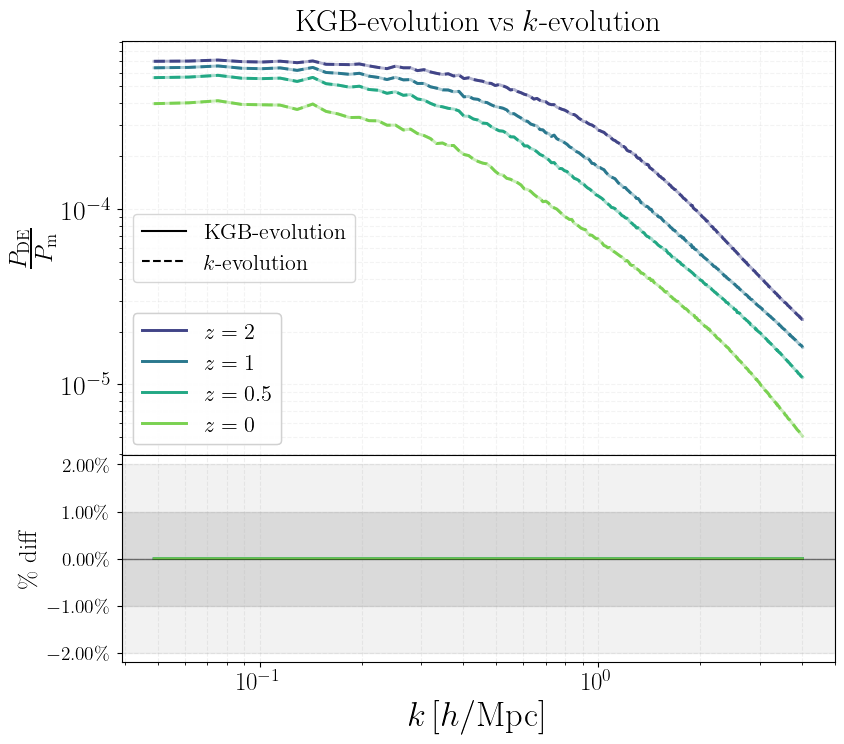

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator, PercentFormatter
import seaborn as sns


# === Your data dicts ===
k_zp           = dict(zip(z, final['k']))
delta_kgb_zp   = dict(zip(z, final['delta_kgb']))
delta_kess_zp  = dict(zip(z_kess, final_kess['delta_kess']))

deltam_kgb_zp   = dict(zip(z, final['delta_unnorm']))
deltam_kess_zp  = dict(zip(z_kess, final_kess['delta_unnorm']))

# === Panels definition (same as before) ===
panels = [
    (
        r" KGB-evolution vs $k$‐evolution ",
        lambda zz: delta_kgb_zp[zz] / deltam_kgb_zp[zz],
        lambda zz: delta_kess_zp[zz]/deltam_kess_zp[zz],
    )
]

# === Figure with GridSpec for main + inset stacked ===
fig = plt.figure(figsize=(9, 8))
gs  = fig.add_gridspec(len(panels)*3, 1, hspace=0.0)  
# 3 "rows" per panel → top 2 for main, bottom 1 for inset (ratio 2:1)

colors = sns.color_palette("viridis", len(target_z)).as_hex()
start_ind = 0

for i, (title, get_kgb, get_kess) in enumerate(panels):
    # Main spectrum axis
    ax_main = fig.add_subplot(gs[i*3:i*3+2, 0])   # takes 2/3 of space
    # Relative difference axis
    ax_rel  = fig.add_subplot(gs[i*3+2, 0], sharex=ax_main)  # takes 1/3
    
    # === Main curves ===
    for color, z_val in zip(colors, target_z):
        k_vals = k_zp[z_val]
        P_kgb  = get_kgb(z_val)
        P_kess = get_kess(z_val)
        
        ax_main.plot(k_vals[start_ind:], P_kess[start_ind:], "--"
          , color=color, linewidth=2.1)
        
        ax_main.plot(k_vals[start_ind:], P_kgb[start_ind:], "-",
             color=color, linewidth=2.1, alpha = 0.4, label=rf"$z={z_val}$")


        # Relative difference
        rel = (P_kgb - P_kess) / P_kess
        ax_rel.plot(k_vals[start_ind:], rel[start_ind:], color=color, linewidth=1.8)

    # === Main formatting ===
    ax_main.set_xscale("log")
    ax_main.set_yscale("log")
    ax_main.set_title(title, fontsize=22, pad=8)
    ax_main.set_ylabel(r"$\frac{P_\mathrm{DE}}{P_\mathrm{m}}$", fontsize=25)
    ax_main.grid(True, which="both", linestyle="--", alpha=0.15)

    ax_main.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2,10), numticks=12))
    ax_main.yaxis.set_major_locator(LogLocator(numticks=15))

    # === Relative difference formatting ===
    ax_rel.axhline(0.0, color="k", linewidth=1.0, alpha=0.5)
    ax_rel.set_xscale("log")
    ax_rel.set_ylabel(r"\% diff", fontsize=18)
    ax_rel.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    ax_rel.grid(True, which="both", linestyle="--", alpha=0.2)
    ax_rel.tick_params(axis="x", labelsize=18)
    ax_rel.tick_params(axis="y", labelsize=14)
    
    # === Add grey bands for 1% and 2% ===
    ax_rel.axhspan(-0.01, 0.01, color="grey", alpha=0.2)  # ±1%
    ax_rel.axhspan(-0.02, 0.02, color="grey", alpha=0.1)  # ±2%

    # === Only bottom panel gets the xlabel ===
    ax_rel.set_xlabel(r"$k\,[h/\mathrm{Mpc}]$", fontsize=25)

    # === Legends on main plot ===
    style_handles = [
        Line2D([0], [0], linestyle='-',  color='black'),
        Line2D([0], [0], linestyle='--', color='black')
    ]
    style_labels = ["KGB-evolution", r"$k$-evolution"]

    style_leg = ax_main.legend(
        handles=style_handles,
        labels=style_labels,
        loc="center left",
        fontsize=16
    )
    ax_main.add_artist(style_leg)

    red_leg = ax_main.legend(
        loc="lower left",
        fontsize=16
    )
    
    # restore full opacity in legend only
    for lh in red_leg.get_lines():
        lh.set_alpha(1)
        
    ax_main.add_artist(red_leg)

fig.tight_layout()
plt.show()


# $\Delta_{{\rm DE}\times {\rm m}}$ cross correlation

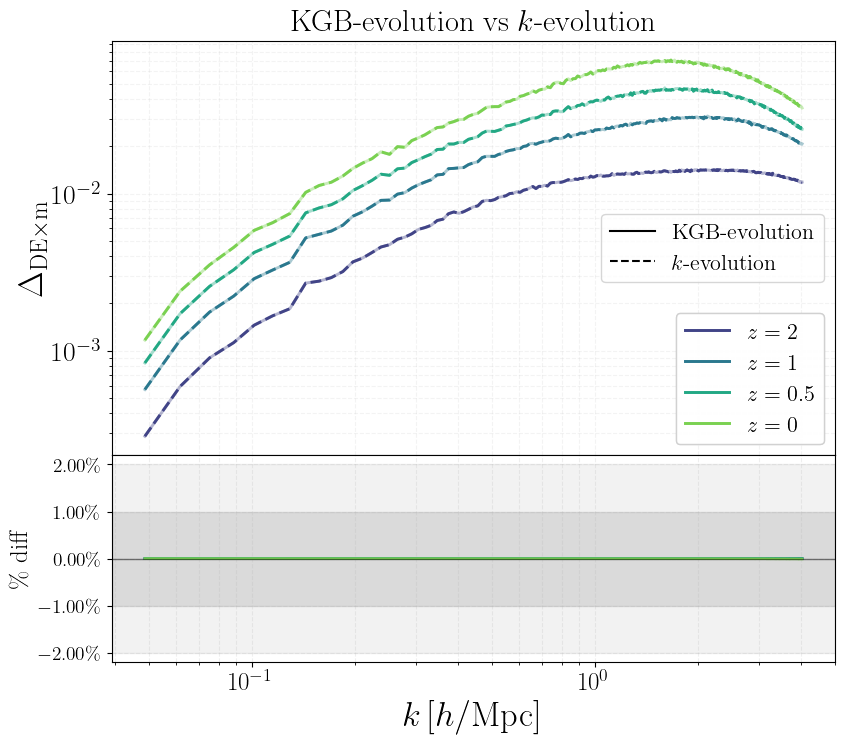

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator, PercentFormatter
import seaborn as sns


# === Your data dicts ===
k_zp           = dict(zip(z, final['k']))
deltakgb_deltam_zp   = dict(zip(z, final['deltakgb_deltam']))
deltakess_deltam_zp  = dict(zip(z_kess, final_kess['deltakess_deltam']))



# === Panels definition (same as before) ===
panels = [
    (
        r" KGB-evolution vs $k$‐evolution ",
        lambda zz: deltakgb_deltam_zp[zz],
        lambda zz: deltakess_deltam_zp[zz],
    )
]

# === Figure with GridSpec for main + inset stacked ===
fig = plt.figure(figsize=(9, 8))
gs  = fig.add_gridspec(len(panels)*3, 1, hspace=0.0)  
# 3 "rows" per panel → top 2 for main, bottom 1 for inset (ratio 2:1)

colors = sns.color_palette("viridis", len(target_z)).as_hex()
start_ind = 0

for i, (title, get_kgb, get_kess) in enumerate(panels):
    # Main spectrum axis
    ax_main = fig.add_subplot(gs[i*3:i*3+2, 0])   # takes 2/3 of space
    # Relative difference axis
    ax_rel  = fig.add_subplot(gs[i*3+2, 0], sharex=ax_main)  # takes 1/3
    
    # === Main curves ===
    for color, z_val in zip(colors, target_z):
        k_vals = k_zp[z_val]
        P_kgb  = get_kgb(z_val)
        P_kess = get_kess(z_val)

        ax_main.plot(k_vals[start_ind:], P_kgb[start_ind:], "-",label=rf"$z={z_val}$",
                     color=color, linewidth=2.1, alpha = 0.4)
        ax_main.plot(k_vals[start_ind:], P_kess[start_ind:], "--"
                     , color=color, linewidth=2.1,)

        # Relative difference
        rel = (P_kgb - P_kess) / P_kess
        ax_rel.plot(k_vals[start_ind:], rel[start_ind:], color=color, linewidth=1.8)

    # === Main formatting ===
    ax_main.set_xscale("log")
    ax_main.set_yscale("log")
    ax_main.set_title(title, fontsize=22, pad=8)
    ax_main.set_ylabel(r"$\Delta_{\mathrm{DE}\times \mathrm{m}}$", fontsize=25)
    ax_main.grid(True, which="both", linestyle="--", alpha=0.15)

    ax_main.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2,10), numticks=12))
    ax_main.yaxis.set_major_locator(LogLocator(numticks=15))

    # === Relative difference formatting ===
    ax_rel.axhline(0.0, color="k", linewidth=1.0, alpha=0.5)
    ax_rel.set_xscale("log")
    ax_rel.set_ylabel(r"\% diff", fontsize=18)
    ax_rel.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    ax_rel.grid(True, which="both", linestyle="--", alpha=0.2)
    ax_rel.tick_params(axis="x", labelsize=18)
    ax_rel.tick_params(axis="y", labelsize=14)
    
    # === Add grey bands for 1% and 2% ===
    ax_rel.axhspan(-0.01, 0.01, color="grey", alpha=0.2)  # ±1%
    ax_rel.axhspan(-0.02, 0.02, color="grey", alpha=0.1)  # ±2%

    # === Only bottom panel gets the xlabel ===
    ax_rel.set_xlabel(r"$k\,[h/\mathrm{Mpc}]$", fontsize=25)

    # === Legends on main plot ===
    style_handles = [
        Line2D([0], [0], linestyle='-',  color='black'),
        Line2D([0], [0], linestyle='--', color='black')
    ]
    style_labels = ["KGB-evolution", r"$k$-evolution"]

    style_leg = ax_main.legend(
        handles=style_handles,
        labels=style_labels,
        loc="center right",
        fontsize=16
    )
    ax_main.add_artist(style_leg)

    red_leg = ax_main.legend(
        loc="lower right",
        fontsize=16
    )
    
    # restore full opacity in legend only
    for lh in red_leg.get_lines():
        lh.set_alpha(1)
        
    ax_main.add_artist(red_leg)

fig.tight_layout()
plt.show()


# $\Delta_X$ normalized cross power spectra

Saving figure norm_cross_DE_m


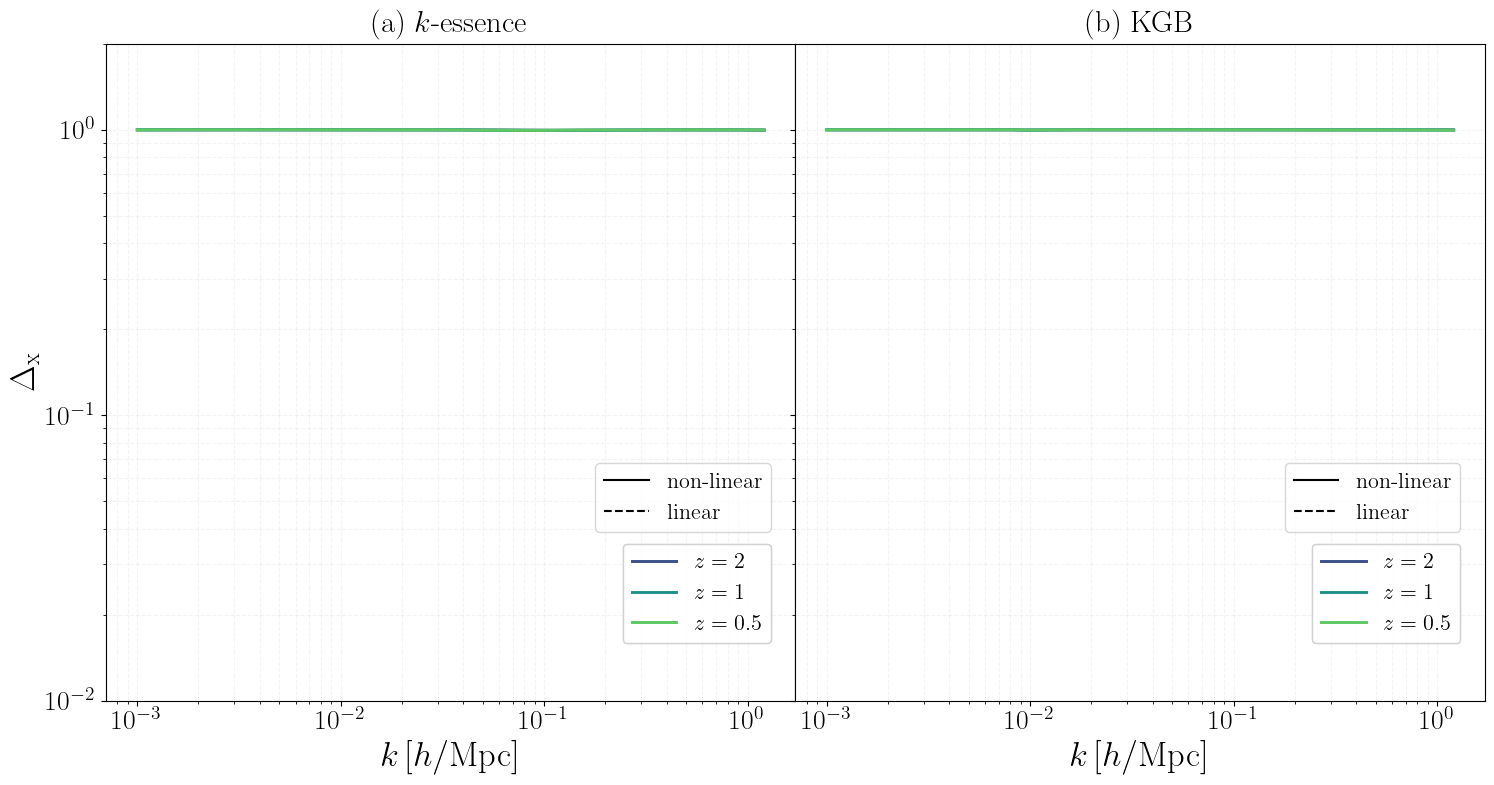

In [230]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import seaborn as sns




# === Plot settings ===
plt.rc("text", usetex=True)
plt.rc("font", family="serif", size=25)
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)

# === Figure and axes ===
fig, axes = plt.subplots(
    1, 2,
    figsize=(15.5, 8.4),
    sharey=True,
    gridspec_kw=dict(wspace=0.0)
)

# === Your data dicts ===
# KGB
k_zp           = dict(zip(z, final['k']))
deltakgb_deltam_zp   = dict(zip(z, final['deltakgb_deltam']))
delta_kgb_zp   = dict(zip(z, final['delta_kgb']))
delta_m_kgb_zp = dict(zip(z, final['delta_unnorm']))

# kess
k_kess_zp           = dict(zip(z, final_kess['k']))
deltakess_deltam_zp = dict(zip(z, final_kess['deltakess_deltam']))
delta_kess_zp  = dict(zip(z, final_kess['delta_kess']))
delta_m_kess_zp = dict(zip(z, final_kess['delta_unnorm']))



k_kess_dict = dict(zip(target_z, k_list_kess))
k_kgb_dict  = dict(zip(target_z, k_list_kgb))

colors = sns.color_palette("viridis", len(target_z)).as_hex()

panels = [
    (
        r"(a) $k$‐essence",
        lambda zz: deltakess_deltam_zp[zz]/(np.sqrt(delta_kess_zp[zz]*delta_m_kess_zp[zz])) ,

        k_kess_dict
    ),
    (
        r"(b) KGB",
        lambda zz: deltakgb_deltam_zp[zz]/(np.sqrt(delta_kgb_zp[zz]*delta_m_kgb_zp[zz])),
        k_kgb_dict
    )
]

start_ind = 0

for i, (ax, (title, get_nl, k_dict)) in enumerate(zip(axes, panels)):
    # Plot each redshift
    for color, z_val in zip(colors, target_z):
        k_vals = k_kess_zp[z_val]
        P_nl   = get_nl(z_val)
        k_sh   = k_dict[z_val]
        
        ax.plot(k_vals[start_ind:], P_nl[start_ind:], "-",
                label=rf"$z={z_val}$", color=color, linewidth=2.1)
#         ax.axvline(x=k_sh, color=color, linestyle=":", linewidth=2, alpha=0.9)

    # Scales & labels
    ax.set_xscale("log")
    ax.set_yscale("log")
#     ax.yaxis.set_minor_locator(
#     LogLocator(base=10.0, subs=np.arange(2,10), numticks=12))
#     ax.yaxis.set_major_locator(LogLocator(numticks=15))
      
    ax.set_title(title, fontsize=22, pad=8)
    ax.set_xlabel(r"$k\,[h/\mathrm{Mpc}]$", fontsize=25)
    ax.grid(True, which="both", linestyle="--", alpha=0.15)
    if i == 0:
        ax.set_ylabel(r"$\Delta_\mathrm{x}$", fontsize=25)
        
    ax.set_ylim(1e-2,2e0)
    ax.yaxis.set_major_locator(LogLocator(
    base=10.0,
    subs=(1.0,),    # only at 1×10^n
    numticks=10     # roughly one tick per decade
))
#     ax.set_yticks(np.linspace(0,1,6))        # majors at 0.,0.2,…,1.0
#     ax.set_yticks(np.linspace(0,1,11), minor=True)
#     ax.minorticks_on()
    # Prepare legend handles
    style_handles = [
        Line2D([0], [0], linestyle='-', color='black'),
        Line2D([0], [0], linestyle='--', color='black')
    ]
    style_labels = ["non-linear", "linear"]

    # Placement parameters for KGB vs k-essence panel

    # Bottom‐right corner inside axes, with style legend just above redshift legend
    style_bbox = (0.98, 0.24)  # (x, y) in axes fraction
    red_bbox   = (0.98, 0.07)
    style_loc  = "lower right"
    red_loc    = "lower right"


    # Draw style legend
    style_leg = ax.legend(
        handles=style_handles,
        labels=style_labels,
        loc=style_loc,
        bbox_to_anchor=style_bbox,
        fontsize=16
    )
    ax.add_artist(style_leg)

    # Draw redshift legend
    red_leg = ax.legend(
        loc=red_loc,
        fontsize=16,
        bbox_to_anchor=red_bbox
    )
    ax.add_artist(red_leg)

fig.tight_layout()
save_fig("norm_cross_DE_m")
plt.show()

In [238]:
np.min(deltakgb_deltam_zp[0.]/(np.sqrt(delta_kgb_zp[0.]*delta_m_kgb_zp[0.])))

0.9785153981795562

# $\pi$  power spectrum

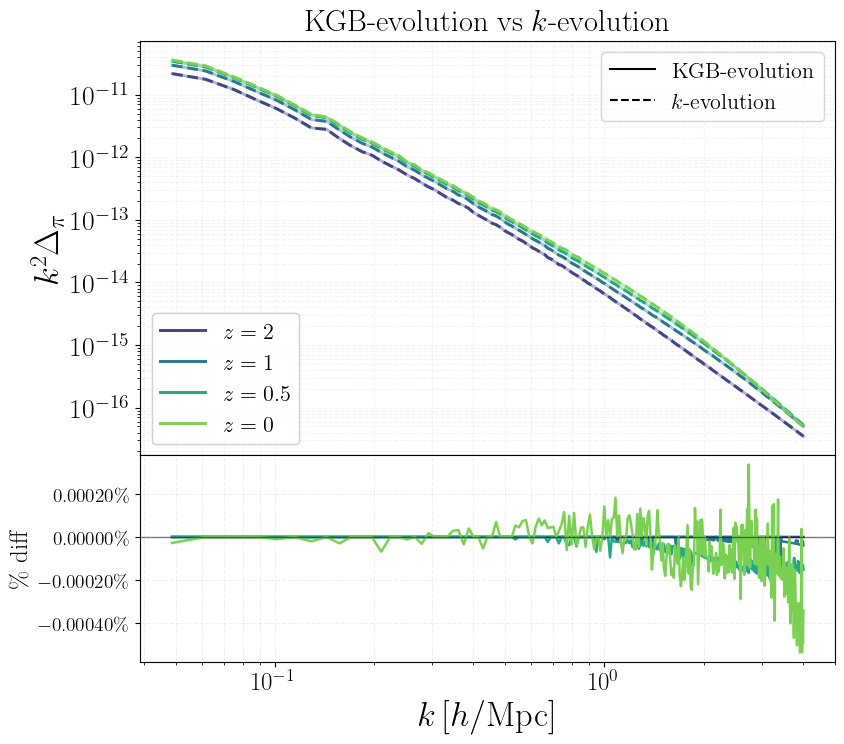

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator, PercentFormatter
import seaborn as sns


# === Your data dicts ===
k_zp           = dict(zip(z, final['k']))
pi_k_kgb_zp   = dict(zip(z, final['pi_k']))
pi_k_kess_zp  = dict(zip(z_kess, final_kess['pi_k']))




# === Panels definition (same as before) ===
panels = [
    (
        r" KGB-evolution vs $k$‐evolution ",
        lambda zz: pi_k_kgb_zp[zz],
        lambda zz: pi_k_kess_zp[zz],
    )
]

# === Figure with GridSpec for main + inset stacked ===
fig = plt.figure(figsize=(9, 8))
gs  = fig.add_gridspec(len(panels)*3, 1, hspace=0.0)  
# 3 "rows" per panel → top 2 for main, bottom 1 for inset (ratio 2:1)

colors = sns.color_palette("viridis", len(target_z)).as_hex()
start_ind = 0

for i, (title, get_kgb, get_kess) in enumerate(panels):
    # Main spectrum axis
    ax_main = fig.add_subplot(gs[i*3:i*3+2, 0])   # takes 2/3 of space
    # Relative difference axis
    ax_rel  = fig.add_subplot(gs[i*3+2, 0], sharex=ax_main)  # takes 1/3
    
    # === Main curves ===
    for color, z_val in zip(colors, target_z):
        k_vals = k_zp[z_val]
        P_kgb  = get_kgb(z_val)
        P_kess = get_kess(z_val)

        ax_main.plot(k_vals[start_ind:], P_kgb[start_ind:], "-",label=rf"$z={z_val}$",
                     color=color, linewidth=2.1, alpha = 0.4)
        ax_main.plot(k_vals[start_ind:], P_kess[start_ind:], "--"
                     , color=color, linewidth=2.1,)

        # Relative difference
        rel = (P_kgb - P_kess) / P_kess
        ax_rel.plot(k_vals[start_ind:], rel[start_ind:], color=color, linewidth=1.8)

    # === Main formatting ===
    ax_main.set_xscale("log")
    ax_main.set_yscale("log")
    ax_main.set_title(title, fontsize=22, pad=8)
    ax_main.set_ylabel(r"$k^2 \Delta_{\pi}$", fontsize=25)
    ax_main.grid(True, which="both", linestyle="--", alpha=0.15)

    ax_main.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2,10), numticks=12))
    ax_main.yaxis.set_major_locator(LogLocator(numticks=15))

    # === Relative difference formatting ===
    ax_rel.axhline(0.0, color="k", linewidth=1.0, alpha=0.5)
    ax_rel.set_xscale("log")
    ax_rel.set_ylabel(r"\% diff", fontsize=18)
    ax_rel.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    ax_rel.grid(True, which="both", linestyle="--", alpha=0.2)
    ax_rel.tick_params(axis="x", labelsize=18)
    ax_rel.tick_params(axis="y", labelsize=14)
    
#     # === Add grey bands for 1% and 2% ===
#     ax_rel.axhspan(-0.01, 0.01, color="grey", alpha=0.2)  # ±1%
#     ax_rel.axhspan(-0.02, 0.02, color="grey", alpha=0.1)  # ±2%

    # === Only bottom panel gets the xlabel ===
    ax_rel.set_xlabel(r"$k\,[h/\mathrm{Mpc}]$", fontsize=25)

    # === Legends on main plot ===
    style_handles = [
        Line2D([0], [0], linestyle='-',  color='black'),
        Line2D([0], [0], linestyle='--', color='black')
    ]
    style_labels = ["KGB-evolution", r"$k$-evolution"]

    style_leg = ax_main.legend(
        handles=style_handles,
        labels=style_labels,
        loc="upper right",
        fontsize=16
    )
    ax_main.add_artist(style_leg)

    red_leg = ax_main.legend(
        loc="lower left",
        fontsize=16
    )
    
    # restore full opacity in legend only
    for lh in red_leg.get_lines():
        lh.set_alpha(1)
        
    ax_main.add_artist(red_leg)

fig.tight_layout()
plt.show()


# $\zeta$ power spectrum

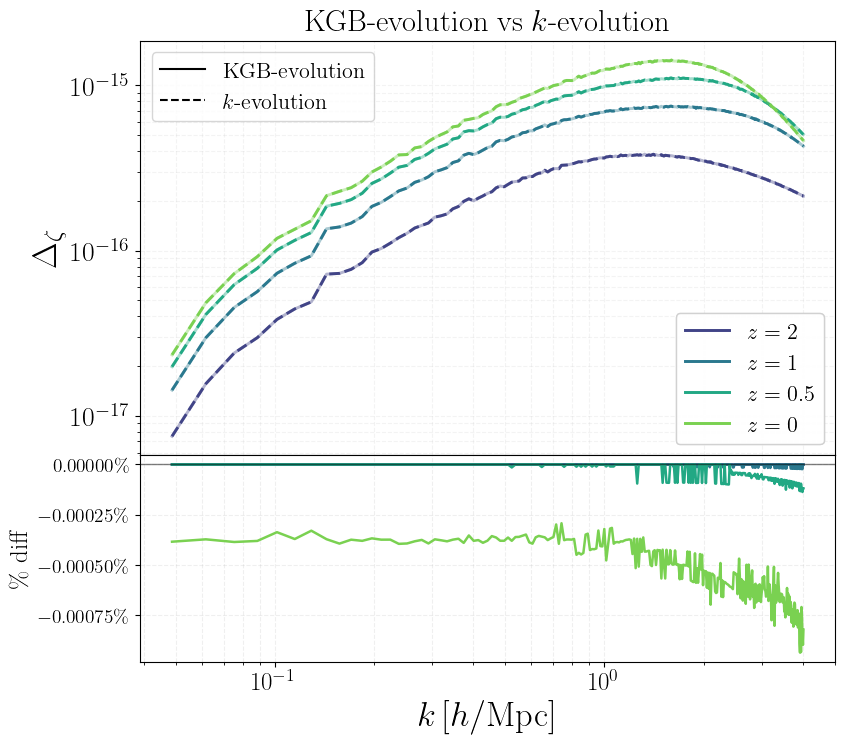

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator, PercentFormatter
import seaborn as sns


# === Your data dicts ===
k_zp           = dict(zip(z, final['k']))
zeta_kgb_zp   = dict(zip(z, final['zeta']))
zeta_kess_zp  = dict(zip(z_kess, final_kess['zeta']))



# === Panels definition (same as before) ===
panels = [
    (
        r" KGB-evolution vs $k$‐evolution ",
        lambda zz: zeta_kgb_zp[zz],
        lambda zz: zeta_kess_zp[zz],
    )
]

# === Figure with GridSpec for main + inset stacked ===
fig = plt.figure(figsize=(9, 8))
gs  = fig.add_gridspec(len(panels)*3, 1, hspace=0.0)  
# 3 "rows" per panel → top 2 for main, bottom 1 for inset (ratio 2:1)

colors = sns.color_palette("viridis", len(target_z)).as_hex()
start_ind = 0

for i, (title, get_kgb, get_kess) in enumerate(panels):
    # Main spectrum axis
    ax_main = fig.add_subplot(gs[i*3:i*3+2, 0])   # takes 2/3 of space
    # Relative difference axis
    ax_rel  = fig.add_subplot(gs[i*3+2, 0], sharex=ax_main)  # takes 1/3
    
    # === Main curves ===
    for color, z_val in zip(colors, target_z):
        k_vals = k_zp[z_val]
        P_kgb  = get_kgb(z_val)
        P_kess = get_kess(z_val)

        ax_main.plot(k_vals[start_ind:], P_kgb[start_ind:], "-",label=rf"$z={z_val}$",
                     color=color, linewidth=2.1, alpha = 0.4)
        ax_main.plot(k_vals[start_ind:], P_kess[start_ind:], "--"
                     , color=color, linewidth=2.1,)

        # Relative difference
        rel = (P_kgb - P_kess) / P_kess
        ax_rel.plot(k_vals[start_ind:], rel[start_ind:], color=color, linewidth=1.8)

    # === Main formatting ===
    ax_main.set_xscale("log")
    ax_main.set_yscale("log")
    ax_main.set_title(title, fontsize=22, pad=8)
    ax_main.set_ylabel(r"$\Delta_{\zeta}$", fontsize=25)
    ax_main.grid(True, which="both", linestyle="--", alpha=0.15)

    ax_main.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2,10), numticks=12))
    ax_main.yaxis.set_major_locator(LogLocator(numticks=15))

    # === Relative difference formatting ===
    ax_rel.axhline(0.0, color="k", linewidth=1.0, alpha=0.5)
    ax_rel.set_xscale("log")
    ax_rel.set_ylabel(r"\% diff", fontsize=18)
    ax_rel.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    ax_rel.grid(True, which="both", linestyle="--", alpha=0.2)
    ax_rel.tick_params(axis="x", labelsize=18)
    ax_rel.tick_params(axis="y", labelsize=14)
    
#     # === Add grey bands for 1% and 2% ===
#     ax_rel.axhspan(-0.01, 0.01, color="grey", alpha=0.2)  # ±1%
#     ax_rel.axhspan(-0.02, 0.02, color="grey", alpha=0.1)  # ±2%

    # === Only bottom panel gets the xlabel ===
    ax_rel.set_xlabel(r"$k\,[h/\mathrm{Mpc}]$", fontsize=25)

    # === Legends on main plot ===
    style_handles = [
        Line2D([0], [0], linestyle='-',  color='black'),
        Line2D([0], [0], linestyle='--', color='black')
    ]
    style_labels = ["KGB-evolution", r"$k$-evolution"]

    style_leg = ax_main.legend(
        handles=style_handles,
        labels=style_labels,
        loc="upper left",
        fontsize=16
    )
    ax_main.add_artist(style_leg)

    red_leg = ax_main.legend(
        loc="lower right",
        fontsize=16
    )
    
    # restore full opacity in legend only
    for lh in red_leg.get_lines():
        lh.set_alpha(1)
        
    ax_main.add_artist(red_leg)

fig.tight_layout()
plt.show()

# $\Phi'$ power spectrum

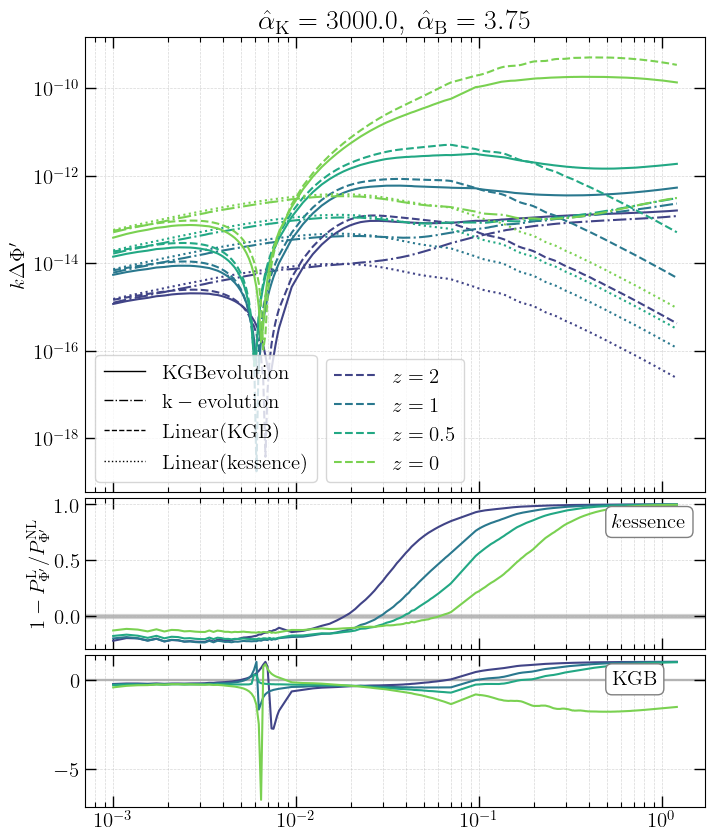

In [147]:
fig, ax = plt.subplots(
    3, 1, gridspec_kw={"height_ratios": [3, 1,1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.022, wspace=0.23)


#c = sns.color_palette("viridis", len(z)).as_hex()

plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}

# simulation
k_zp     = dict(zip(z, final['k']))
phi_prime_zp = dict(zip(z, final['phi_prime']))

# simulation kessence
phi_prime_kess_zp = dict(zip(z, final_kess['phi_prime']))


# hiclass
Pk_phi_prime_kgb_zp  = dict(zip(z, Pk_phi_prime_kgb))
Pk_phi_prime_kess_zp = dict(zip(z, Pk_phi_prime_kess))




colors = sns.color_palette("viridis", len(target_z)).as_hex()



for c, zv in zip(colors, target_z):
    
    # simulation
    k_vals     = k_zp[zv]
    phi_prime_vals = k_vals*h*phi_prime_zp[zv]
    phi_prime_kess_vals = k_vals*h*phi_prime_kess_zp[zv]
    
    # hiclass
    Pk_phi_prime_kgb_vals = Pk_phi_prime_kgb_zp[zv]
    Pk_phi_prime_kess_vals = Pk_phi_prime_kess_zp[zv]
    

    #############################################################################
    #                                         hiclass
    
    
    ax[0].plot(
        k_vals,
        Pk_phi_prime_kgb_vals,"--",
        label=f"$z={zv}$",
        c = c,
        alpha = 1,
        markersize=6
    )
    
    
    ax[0].plot(
        k_vals,
        Pk_phi_prime_kess_vals,":",
        c = c,
        markersize=6
    )
    
    
    #############################################################################
    #                                         KGB-evolution
    if show_sim_plots:
        
        ax[0].plot(
            k_vals,
            phi_prime_kess_vals,"-.",
            c = c,
            alpha =1,
            markersize=6
        )
    
        ax[0].plot(
            k_vals,
            phi_prime_vals,"-",
            c = c,
            alpha =1,
            markersize=6
        )
    
    
    
    
    
    ##############################################################################
    #                                         Rel Diff
    
    ax[1].plot(
        kk,
        (1-np.array(Pk_phi_prime_kess_vals)/phi_prime_kess_vals),"-",
        c = c,
        markersize=6
    )
    
    ax[2].plot(
        kk,
        (1-np.array(Pk_phi_prime_kgb_vals)/phi_prime_vals),"-",
        c = c,
        markersize=6
    )


    
    
linestyles = ["-","-.", "--", ":"]
lines = [Line2D([0], [0], color="black", linewidth=1, linestyle=l) for l in linestyles]
labels = [f"$\mathrm{{KGBevolution}}$ ", f"$\mathrm{{k-evolution}}$ ",f"$\mathrm{{Linear(KGB)}}$", f"$\mathrm{{Linear(kessence)}}$"]



leg2 = ax[0].legend(lines, labels, loc="lower left", fontsize=15)

ax[0].add_artist(leg2)

ax[0].legend(fontsize=15)    
    
    
for i in range (1,3):
    #ax[i].set_ylim(-0.2,0.2)

    ax[i].axhspan(-0.01, 0.01, color="gray", alpha=0.3)
    ax[i].axhspan(-0.02, 0.02, color="gray", alpha=0.2)

for i in range(3):
    ax[i].set_xscale("log")
    

    # plt.xlim(5.0e-5, 0.01)
    # plt.ylim(1.e-17,3.e-9)
    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5, alpha = 0.5)


    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


ax[0].set_yscale("log")
ax[0].set_ylabel(r"$k\Delta\Phi'$", fontsize=15)
ax[1].set_ylabel(r"$1-P_{\Phi'}^\mathrm{L}/P_{\Phi'}^\mathrm{NL}$", fontsize=15)
ax[1].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)

ax[1].text(.85, 0.9, r'$k\mathrm{essence}$',
           transform=ax[1].transAxes,
           fontsize=15, ha='left', va='top',
           bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))
ax[2].text(0.85, 0.9, r'$\mathrm{KGB}$',
           transform=ax[2].transAxes,
           fontsize=15, ha='left', va='top',
           bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))


ax[0].legend(
    fontsize=15,  # Font size
    loc="lower center",  # Place legend above the plot
#     bbox_to_anchor=(1.23, 1.03),  # Position outside plot area (x, y relative to axes)
#     ncol=1,  # Number of columns
)





ax[0].set_title(
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

#save_fig("matter_power_spectrum")

# $\pi$ power spectra

# $\zeta$ power spectra

# $\mu$ function

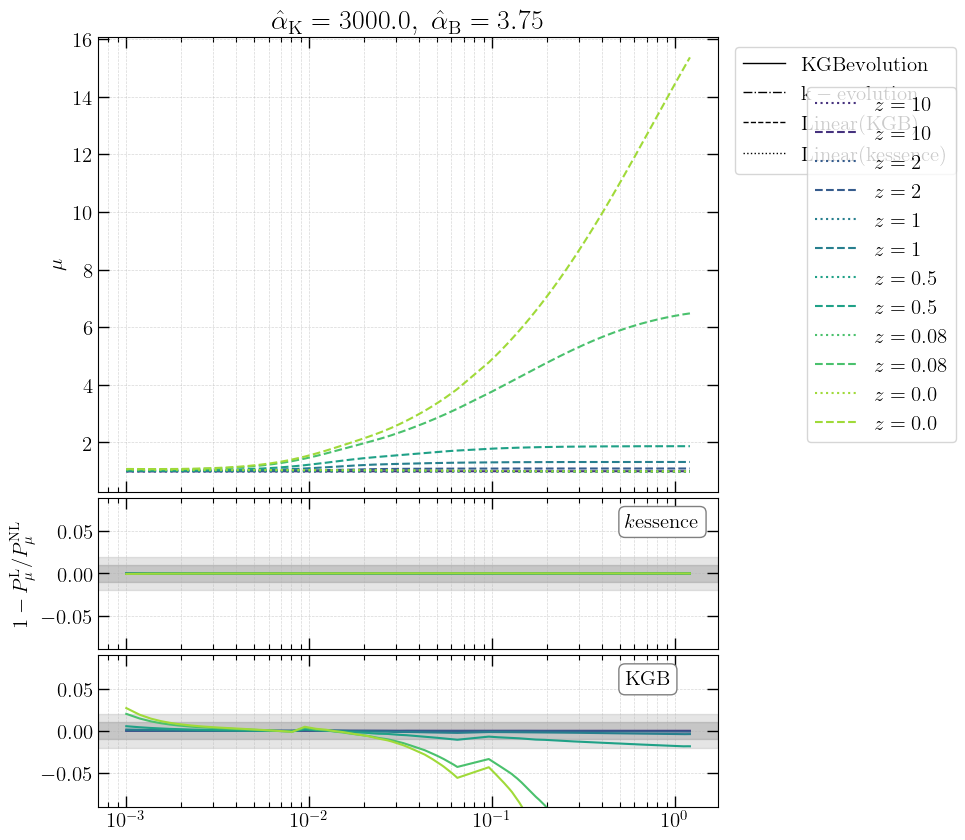

In [10]:
fig, ax = plt.subplots(
    3, 1, gridspec_kw={"height_ratios": [3, 1,1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.022, wspace=0.23)


#c = sns.color_palette("viridis", len(z)).as_hex()

plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}

# simulation KGB
k_zp     = dict(zip(z, final['k']))
mu_kgb_zp = dict(zip(z, final['mu']))


# simulation kessence
mu_kess_zp = dict(zip(z, final_kess['mu']))


# hiclass
Pk_mu_kgb_zp  = dict(zip(z, mu_kgb))
Pk_mu_kess_zp = dict(zip(z, mu_kess))



colors = sns.color_palette("viridis", len(target_z)).as_hex()



for c, zv in zip(colors, target_z):
    
    # simulation
    k_vals     = k_zp[zv]
    mu_kgb_vals = mu_kgb_zp[zv]
    mu_kess_vals = mu_kess_zp[zv]
    
    # hiclass
    Pk_mu_kgb_vals = Pk_mu_kgb_zp[zv]
    Pk_mu_kess_vals = Pk_mu_kess_zp[zv]
    

    #############################################################################
    #                                         hiclass
    
    
    ax[0].plot(
        k_vals,
        Pk_mu_kess_vals,":",
        label=f"$z={zv}$",
        c = c,
        markersize=6
    )
    
    ax[0].plot(
        k_vals,
        Pk_mu_kgb_vals,"--",
        label=f"$z={zv}$",
        c = c,
        alpha = 1,
        markersize=6
    )
    

    
    
    #############################################################################
    #                                         KGB-evolution
    
#     if show_sim_plots:
        
#         ax[0].plot(
#             k_vals,
#             mu_kess_vals,"-.",
#             c = c,
#             alpha =1,
#             markersize=6
#         )
        
#         ax[0].plot(
#             k_vals,
#             mu_kgb_vals,"-",
#             c = c,
#             alpha =1,
#             markersize=6
#         )

    
    
    
    
#     ##############################################################################
#     #                                         Rel Diff
    
    ax[1].plot(
        kk,
        (1-np.array(Pk_mu_kess_vals)/mu_kess_vals),"-",
        c = c,
        markersize=6
    )
    
    ax[2].plot(
        kk,
        (1-np.array(Pk_mu_kgb_vals)/mu_kgb_vals),"-",
        c = c,
        markersize=6
    )
    


    
    

linestyles = ["-","-.", "--", ":"]
lines = [Line2D([0], [0], color="black", linewidth=1, linestyle=l) for l in linestyles]
labels = [f"$\mathrm{{KGBevolution}}$ ", f"$\mathrm{{k-evolution}}$ ",f"$\mathrm{{Linear(KGB)}}$", f"$\mathrm{{Linear(kessence)}}$"]



leg2 = ax[0].legend(lines, labels, loc="upper right",  bbox_to_anchor=(1.4, 1.0), fontsize=15)

ax[0].add_artist(leg2)

ax[0].legend(fontsize=15)    
    
#ax[0].set_ylim(1,10)    

for i in range (1,3):
    ax[i].set_ylim(-0.09,0.09)

    ax[i].axhspan(-0.01, 0.01, color="gray", alpha=0.3)
    ax[i].axhspan(-0.02, 0.02, color="gray", alpha=0.2)

for i in range(3):
    ax[i].set_xscale("log")
    


    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5, alpha = 0.5)


    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


#ax[0].set_yscale("log")
ax[0].set_ylabel(r"$\mu$", fontsize=15)
ax[1].set_ylabel(r"$1-P_{\mu}^\mathrm{L}/P_{\mu}^\mathrm{NL}$", fontsize=15)
ax[1].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)

ax[1].text(.85, 0.9, r'$k\mathrm{essence}$',
           transform=ax[1].transAxes,
           fontsize=15, ha='left', va='top',
           bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))
ax[2].text(0.85, 0.9, r'$\mathrm{KGB}$',
           transform=ax[2].transAxes,
           fontsize=15, ha='left', va='top',
           bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))


ax[0].legend(
    fontsize=15,  # Font size
    loc="center right",  # Place legend above the plot
    bbox_to_anchor=(1.4, 0.5)
#     bbox_to_anchor=(1.23, 1.03),  # Position outside plot area (x, y relative to axes)
#     ncol=1,  # Number of columns
)





ax[0].set_title(
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

#save_fig("matter_power_spectrum")

# $w(z)$

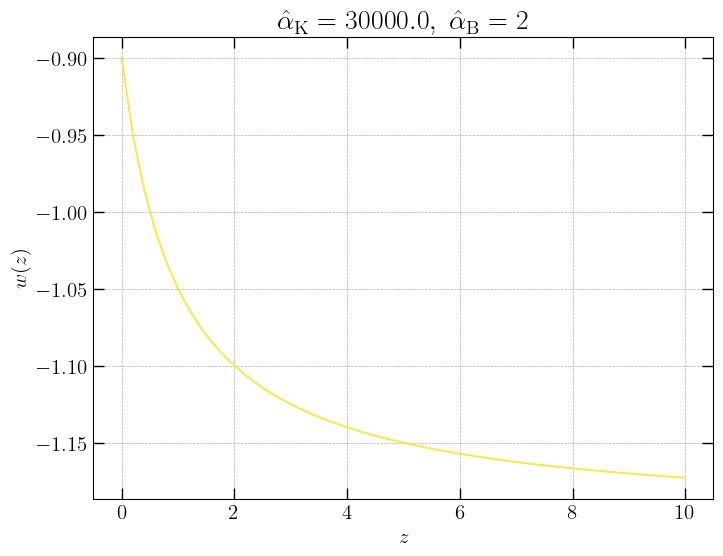

In [13]:
fig, ax = plt.subplots(
    1, 1, figsize=(8, 6), sharex=True
)
plt.subplots_adjust(hspace=0.022, wspace=0.23)


c = sns.color_palette("viridis", len(z)).as_hex()

plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}

#z = list(range(10, -1, -1))
z = list(np.arange(10, -0.001, -0.2))


ax.plot(
    z,
    p_smg(z)/rho_smg(z),"-",
    c = c[zind],
    #label="hiclass_kgb, $z=$" + str(z[zind]),
    alpha = 0.8,
    markersize=6
)


ax.grid(which="both", axis="both", linestyle="--", linewidth=0.5)
ax.tick_params("both", length=8, width=1, which="major")
ax.tick_params("both", length=3.5, width=0.8, which="minor")
ax.tick_params(direction="in", which="major", labelsize=15)
ax.tick_params(direction="in", which="minor")
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")


#ax[0].set_yscale("log")
ax.set_ylabel(r"$w(z)$", fontsize=15)
#ax[1].set_ylabel(r"$1-P_\mathrm{kess}/P_\mathrm{kgb}~ [\%]$", fontsize=15)
ax.set_xlabel("$z$", fontsize=15)


ax.set_title(
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}
